# Great Energy Predictor - EDA

<a id='content2'></a>
## Content

1. [Data Description](#description2)
2. [Imports](#imports2)
3. [Exploratory Analysis](#eda)
    - [Building Analysis](#eda_bldg)
    - [Weather Analysis](#eda_wthr)
    - [Meter Analysis](#eda_metr)

<a id='description2'></a>
## 1. Data Description
[Back to top](#content2)

The data is a 2016 collection of energy meter readings (from over 1,000 buildings in 16 sites around the world) and weather measurements (from the nearest weather station for each site). It consists of 3 relational files of tabular data with the following features:
##### 1. train.csv - contains energy consumption measurements from 4 types of building meters in 2016
    - building_id - identifies the building
        - There are 1449 buildings in 16 sites around the world in this dataset
    - meter - meter type (not all buildings have all meter types)
        - 0 - electricity
        - 1 - chilldwater
        - 2 - steam
        - 3 - hotwater
    - timestamp - date and time of the meter reading
        - This dataset contains measurements over a span of an entire year
    - meter_reading - Energy consumption, in kilowatt-hour (kWh) or equivalent
        - This is the target variable
##### 2. weather_train.csv - contains weather measurements in 2016 from the weather station that is closest to the site
    - site_id - identifies the site where the building is
    - timestamp - date and time of the weather measurements
    - air_temperature - air temperature, in degrees Celsius
    - cloud_coverage - portion of the sky covered by clouds, in oktas
    - dew_temperature - temperature at which dew forms, in degrees Celsius
    - precip_depth_1_hr - measure of rainfail in 1 hour, in millimeters (mm)
    - sea_level_pressure - atmospheric pressure at sea level, in millibar (mbar) or hectopascals (hPa)
    - wind_direction - compass direction of the wind (0 - 360)
    - wind_speed - wind speed, in meters per second (m/s)
##### 3. building_metadata.csv - contains details about the buildings in the dataset
    - site_id - identifies the site where the building is
    - building_id - identifies the building
    - primary_use - what the building is used for (based on EnergyStar's property types)
    - square_feet - gross floor area of the building, in square feet (ft^2)
    - year_built - year the building was opened
    - floor_count - number of floors the building has
    
This data was retrieved from a public Kaggle competition hosted by ASHRAE.
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction/data

<a id='imports2'></a>
## 2. Imports
[Back to top](#content2)

##### Import libraries

In [1]:
%matplotlib inline

import gc
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# import ray.dataframe as pd
# import stumpy
# from fbprophet import Prophet as fb

In [2]:
# Default plot settings
sns.set(rc={'figure.figsize': (16, 4), 
            'font.size': 12})

##### Import data

In [3]:
data_path = '../data/output/'

In [4]:
dtypes = {
    'site_id': 'uint8',
    'building_id': 'uint16',
    'primary_use': 'category',
    'square_feet': 'uint32',
    'year_built': 'uint16',
    'floor_count': 'uint8',
    'in_construction': 'uint8'
}

In [5]:
building = pd.read_csv(f'{data_path}clean_building.csv', dtype=dtypes)
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 8 columns):
Unnamed: 0         1449 non-null int64
site_id            1449 non-null uint8
building_id        1449 non-null uint16
primary_use        1449 non-null category
square_feet        1449 non-null uint32
year_built         1449 non-null uint16
floor_count        1449 non-null uint8
in_construction    1449 non-null uint8
dtypes: category(1), int64(1), uint16(2), uint32(1), uint8(3)
memory usage: 29.2 KB


In [6]:
dtypes = {
    'site_id': 'uint8',
    'air_temperature': 'float32',
    'cloud_coverage': 'uint8',
    'dew_temperature': 'float32',
    'precip_depth_1_hr': 'float32',
    'sea_level_pressure': 'float32',
    'wind_direction': 'uint16',
    'wind_speed': 'float32'
}

In [7]:
weather = pd.read_csv(f'{data_path}clean_weather.csv', dtype=dtypes, parse_dates=['timestamp'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 10 columns):
Unnamed: 0            140544 non-null int64
site_id               140544 non-null uint8
timestamp             140544 non-null datetime64[ns]
air_temperature       140544 non-null float32
cloud_coverage        140544 non-null uint8
dew_temperature       140544 non-null float32
precip_depth_1_hr     140544 non-null float32
sea_level_pressure    140544 non-null float32
wind_direction        140544 non-null uint16
wind_speed            140544 non-null float32
dtypes: datetime64[ns](1), float32(5), int64(1), uint16(1), uint8(2)
memory usage: 5.4 MB


In [8]:
dtypes = {
    'site_id': 'uint8',
    'building_id': 'uint16',
    'meter': 'uint8',
    'type': 'category',
    'meter_reading': 'float32'
}

In [9]:
meter = pd.read_csv(f'{data_path}clean_meter.csv', dtype=dtypes, parse_dates=['timestamp'])
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 7 columns):
Unnamed: 0       int64
site_id          uint8
building_id      uint16
meter            uint8
type             category
timestamp        datetime64[ns]
meter_reading    float32
dtypes: category(1), datetime64[ns](1), float32(1), int64(1), uint16(1), uint8(2)
memory usage: 482.0 MB


In [10]:
# Drop the 1st column
building.drop('Unnamed: 0', axis=1, inplace=True)
weather.drop('Unnamed: 0', axis=1, inplace=True)
meter.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
del dtypes
gc.collect()

1491

<a id='eda'></a>
## 3. Exploratory Analysis
To:
- [Building Analysis](#eda_bldg)
- [Weather Analysis](#eda_wthr)
- [Meter Analysis](#eda_metr)
- [Top](#content2)

<a id='eda_bldg'></a>
### Building Analysis
[Back to 3. Exploratory Analysis](#eda)

##### Inspect the data

In [12]:
building.describe()

site_id  building_id    square_feet   year_built  floor_count  \
count  1449.000000  1449.000000    1449.000000  1449.000000  1449.000000   
mean      6.952381   724.000000   92111.776398  1967.115252     3.557626   
std       5.003432   418.434583  110769.950997    21.768143     3.371705   
min       0.000000     0.000000     283.000000  1900.000000     1.000000   
25%       3.000000   362.000000   23012.000000  1961.000000     1.000000   
50%       5.000000   724.000000   57673.000000  1964.000000     2.000000   
75%      13.000000  1086.000000  115676.000000  1973.000000     4.000000   
max      15.000000  1448.000000  875000.000000  2017.000000    26.000000   

       in_construction  
count      1449.000000  
mean          0.005521  
std           0.074124  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           0.000000  
max           1.000000

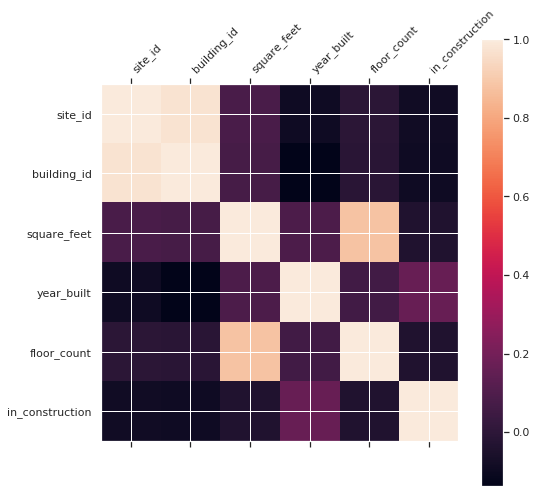

In [13]:
fig = plt.figure(figsize=(8, 8))

plt.matshow(building.corr(), fignum=fig.number)
plt.yticks(range(building.corr().shape[0]), building.corr().columns)
plt.xticks(range(building.corr().shape[0]), building.corr().columns, rotation=45, ha='left')
plt.colorbar()

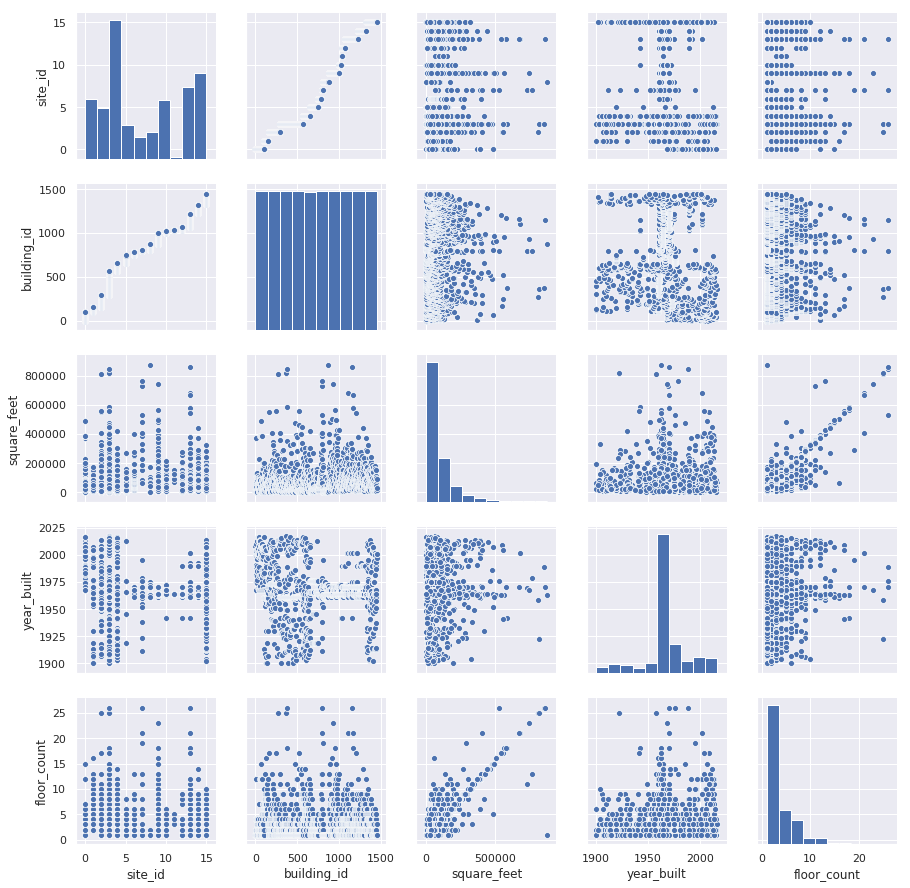

In [14]:
sns.pairplot(building.drop('in_construction', axis=1))

##### Visualize the data by site

Text(0.5, 1.0, 'Buildings in each site')

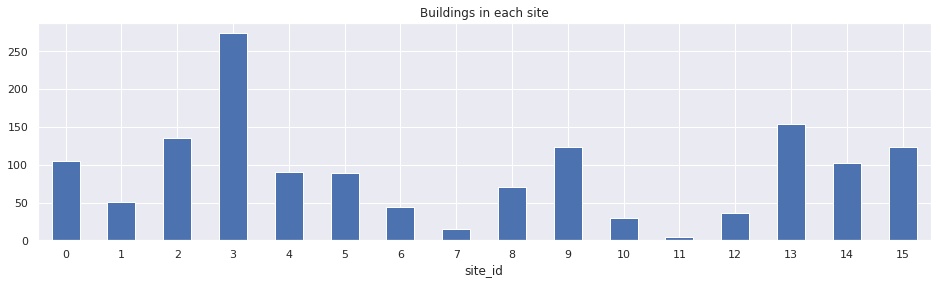

In [15]:
# Amount of buildings in each site
building.groupby('site_id').building_id.count().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Buildings in each site')

In [16]:
# Average values for each site
avg_bysite = building.groupby('site_id').mean().astype(int)[['square_feet', 'year_built', 'floor_count']]

# Total average values for all sites
avg_bysite.loc['All'] = avg_bysite.mean() 

avg_bysite

square_feet  year_built  floor_count
site_id                                      
0           86394.00      1995.0       3.0000
1           65002.00      1961.0       7.0000
2           99542.00      1974.0       3.0000
3           75290.00      1961.0       2.0000
4           92876.00      1954.0       5.0000
5           47612.00      1962.0       2.0000
6           91857.00      1966.0       3.0000
7          323634.00      1958.0       8.0000
8           29712.00      1964.0       1.0000
9          144874.00      1965.0       4.0000
10          71152.00      1965.0       2.0000
11         104563.00      1964.0       3.0000
12          79338.00      1966.0       2.0000
13         128342.00      1970.0       4.0000
14          95111.00      1969.0       3.0000
15          83921.00      1962.0       3.0000
All        101201.25      1966.0       3.4375

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

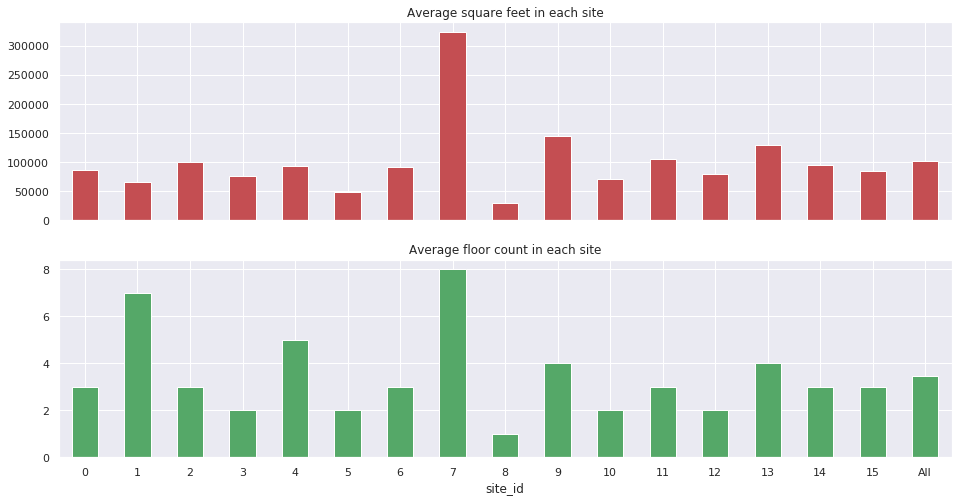

In [17]:
# Subplot titles
titles = ['Average %s in each site' % col for col in ['square feet', 'floor count']]

# Average square_feet and floor_count
avg_bysite.drop('year_built', axis=1).plot(kind='bar', subplots=True, figsize=(16, 8), title=titles, legend=False, color=['r', 'g'])
plt.xticks(rotation=0)

Text(0.5, 1.0, 'Average year built of buildings in each site')

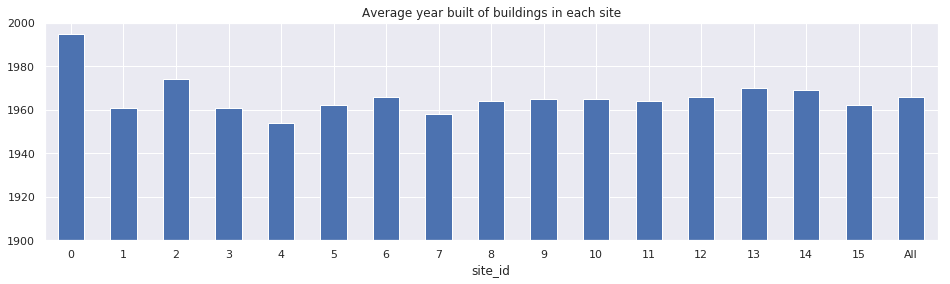

In [18]:
# Average year_built
avg_bysite.year_built.plot(kind='bar')
plt.ylim(1900, 2000)
plt.xticks(rotation=0)
plt.title('Average year built of buildings in each site')

Text(0.5, 1.0, 'Types of buildings')

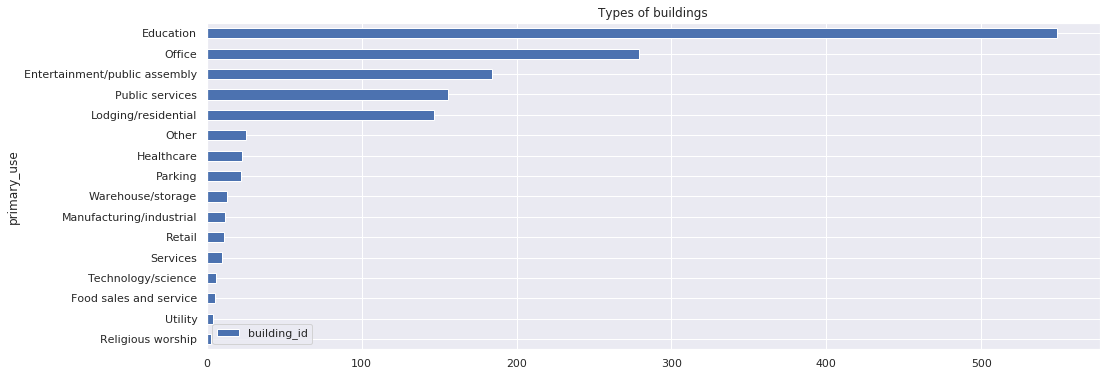

In [19]:
# Amount of buildings by type
use_ct = building.groupby('primary_use')[['building_id']].count().sort_values('building_id')

use_ct.plot(kind='barh', figsize=(16, 6))
plt.title('Types of buildings')

In [20]:
# Amount of each type of building in each site
use_bysite = building.groupby(['site_id', 'primary_use']).building_id.count()
use_bysite = use_bysite.unstack('primary_use', 0)
use_bysite

primary_use  Education  Entertainment/public assembly  Food sales and service  \
site_id                                                                         
0                   30                              5                       0   
1                   22                              1                       0   
2                   61                             21                       2   
3                   92                             44                       0   
4                   66                              9                       0   
5                   49                             18                       0   
6                   15                              4                       0   
7                   15                              0                       0   
8                    0                             24                       0   
9                   63                             18                       0   
10                  14                              4                       0   
11                   5                              0                       0   
12                  20                              2                       0   
13                  25                              8                       1   
14                  26                             10                       2   
15                  46                             16                       0   

primary_use  Healthcare  Lodging/residential  Manufacturing/industrial  \
site_id                                                                  
0                     0                   27                         0   
1                     0                   10                         0   
2                     1                   12                         0   
3                     6                   11                         0   
4                     0                    4                         0   
5                     1                    1                         3   
6                     0                   12                         0   
7                     0                    0                         0   
8                     0                    0                         0   
9                     0                   19                         0   
10                    0                    3                         0   
11                    0                    0                         0   
12                    0                    0                         0   
13                    4                   10                         6   
14                   10                    9                         0   
15                    1                   29                         3   

primary_use  Office  Other  Parking  Public services  Religious worship  \
site_id                                                                   
0                24      5        8                0                  0   
1                16      0        0                2                  0   
2                24      0        3                6                  1   
3                23      4        1               86                  1   
4                 0      0        3                6                  0   
5                11      1        0                5                  0   
6                11      0        0                2                  0   
7                 0      0        0                0                  0   
8                 7      9        0               28                  0   
9                17      0        0                2                  0   
10                5      3        0                0                  0   
11                0      0        0                0                  0   
12                9      0        0                1                  0   
13               75      3        7                5                  0   
14      

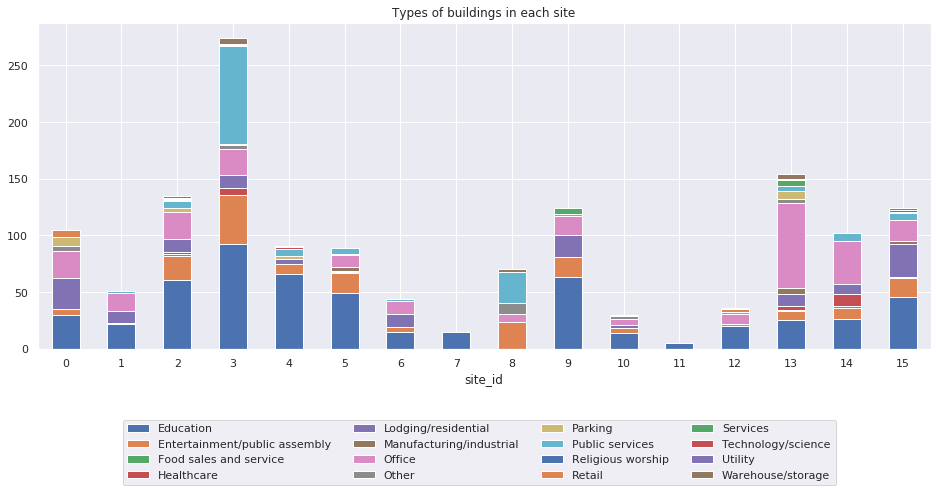

In [21]:
# Building type makeup of each site
use_bysite.plot(kind='bar', stacked=True, figsize=(16, 6))
plt.xticks(rotation=0)
plt.title('Types of buildings in each site')
plt.legend(bbox_to_anchor=(0.9, -0.2), ncol=4, fancybox=True)

In [22]:
del use_bysite, avg_bysite, titles, fig

Average `square_feet`, `floor_count`, and `year_built` by site:
- Site 3 has the most buildings so it has the most weight on the total
    - Half of the `year_built` values and all of the `floor_count` values in site 3 were originally missing
        - The missing `year_built` values were imputed with the median `year_built` of the corresponding type of building
        - The missing `floor_count` values were imputed based on the buildings' `square_feet` divided into 26 bins
- Site 7 has the largest buildings on average, both in terms of `square_feet` and `floor_count`
    - But it also has the 2nd least amount of buildings so there's actually less weight on this site
- Site 1 and site 4 also have taller buildings on average
- Most of the buildings in site 8 have only 1 floor
- Site 0 has a lot of newer buildings

Summary of `primary_use`:
- Education and office buildings make up more than half of the buildings
- Some, if not most, of these sites may be universities
    - Education buildings are a major portion of every site except site 8
- Sites 13 and 14 may be commercial areas since they contain a lot of office buildings
- Sites 3 and 8 have a lot of public services buildings

Note: These insights only reflect the buildings in the data.

##### Visualize the data by the type of building

In [23]:
# Average values for each building type
avg_byuse = building.groupby('primary_use').mean().astype(int)[['square_feet', 'year_built', 'floor_count']]

# Sort based on the amount of each building type present in the data
avg_byuse = avg_byuse.reindex(use_ct.index)

avg_byuse

square_feet  year_built  floor_count
primary_use                                                        
Religious worship                    11276        1974            1
Utility                              31095        1975            1
Food sales and service               38485        1992            1
Technology/science                   59176        1940            3
Services                            200659        1967            6
Retail                               39298        1992            1
Manufacturing/industrial             41120        1963            1
Warehouse/storage                    45584        1976            2
Parking                             279341        1997            8
Healthcare                          140480        1986            4
Other                                31456        1972            1
Lodging/residential                  85368        1970            3
Public services                      64947        1962            2
Entertainment/public assembly        80584        1966            3
Office                               87065        1970            3
Education                           104329        1963            4

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

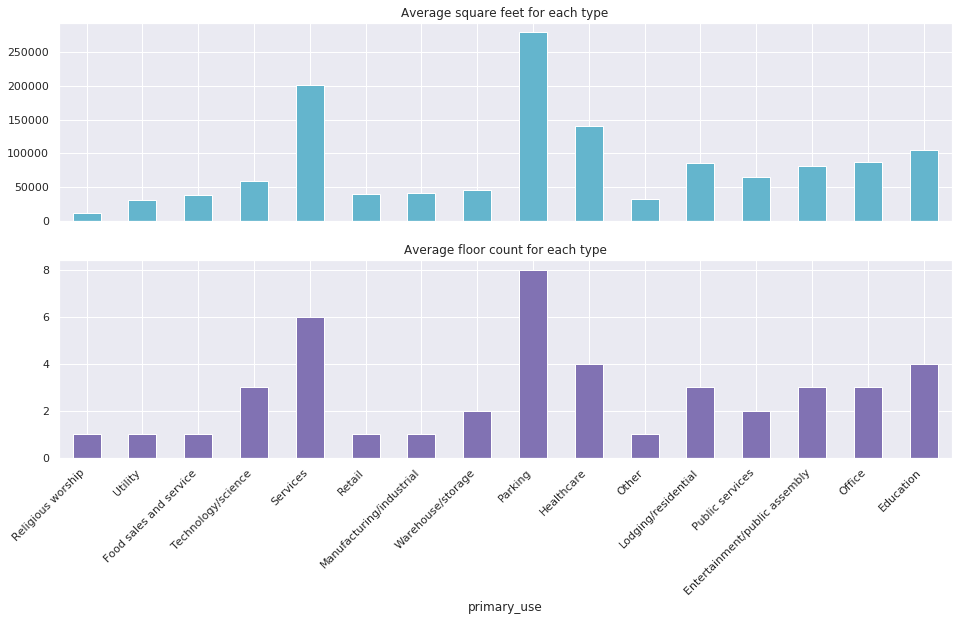

In [24]:
# Subplot titles
titles = ['Average %s for each type' % col for col in ['square feet', 'floor count']]

# Average square_feet and floor_count
avg_byuse[['square_feet', 'floor_count']].plot(kind='bar', subplots=True, figsize=(16, 8), title=titles, legend=False, color=['c', 'm'])
plt.xticks(rotation=45, ha='right')

Text(0.5, 1.0, 'Average year built of buildings for each type')

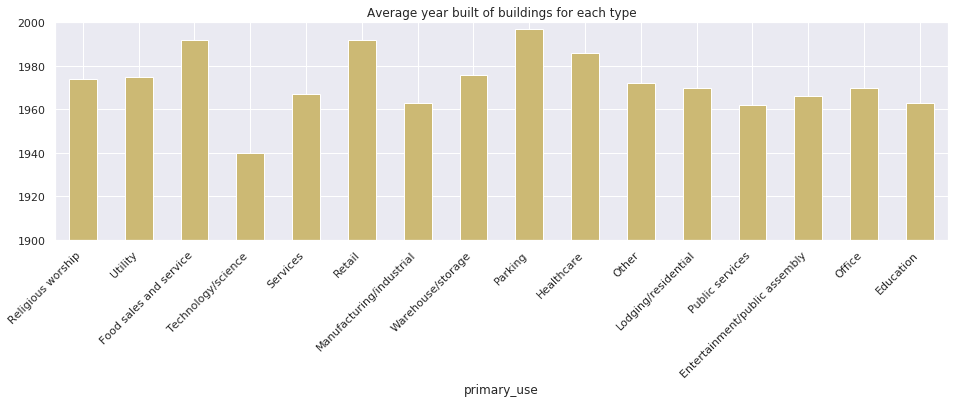

In [25]:
# Average year_built
avg_byuse.year_built.plot(kind='bar', figsize=(16, 4), color='y')
plt.ylim(1900, 2000)
plt.xticks(rotation=45, ha='right')
plt.title('Average year built of buildings for each type')

In [26]:
del use_ct, avg_byuse, titles

Average `square_feet`, `year_built`, and `floor_count` for each type of building:
- As education and office buildings populate more than half of the data, it's natural to see their averages line up with the total averages because they have more weight in contributing to the total averages
- The largest buildings on average (in terms of `square_feet` and `floor_count`) are parking structures, followed by service buildings then health care buildings
- On average, the tallest buildings are technology/science buildings, which are also the oldest buildings
- The newest buildings on average are retail, parking structures, and food sales/services

##### Check the distribution and outliers of the `square_feet` column

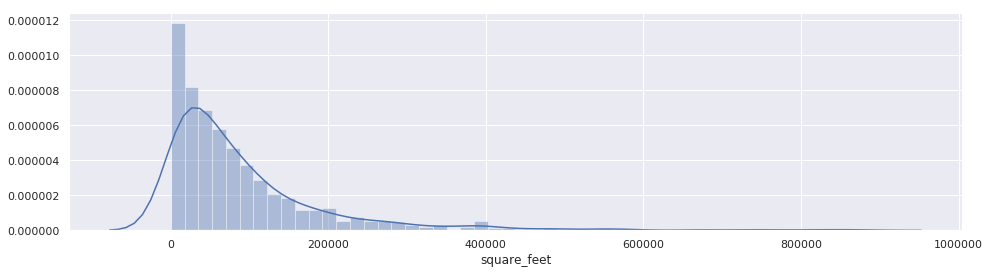

In [27]:
sns.distplot(building.square_feet)

In [28]:
# Use the mean + 3 standard deviations as a standard to filter for outliers
mean_3std = int(building.square_feet.mean() + (3 * building.square_feet.std()))

# Find outliers
building[building.square_feet > mean_3std].shape[0]

29

In [29]:
del mean_3std
gc.collect()

1002

The `square_feet` values are very skewed to the right with about 29 outliers. The threshold for defining outliers here was anything larger than the mean plus 3 standard deviations, which in a normal distribution, contains 99.7% of the data.* Since a lot of the `year_built` and `floor_count` data was originally missing, plotting the distribution won't give any meaningful information because it wouldn't be an accurate representation of the real data.

Note: The `square_feet` data is not normally distributed. This outlier definition was an arbitrary choice.

<a id='eda_wthr'></a>
### Weather Analysis
[Back to 3. Exploratory Analysis](#eda)

##### Inspect the data

In [30]:
weather.describe()

site_id  air_temperature  cloud_coverage  dew_temperature  \
count  140544.000000    140544.000000   140544.000000    140544.000000   
mean        7.500000        14.355564        2.474535         7.297695   
std         4.609789        10.669825        2.641932         9.824859   
min         0.000000       -28.900000        0.000000       -35.000000   
25%         3.750000         7.200000        0.000000         0.600000   
50%         7.500000        15.000000        2.000000         8.200000   
75%        11.250000        22.200001        4.000000        14.400000   
max        15.000000        47.200001        9.000000        26.100000   

       precip_depth_1_hr  sea_level_pressure  wind_direction     wind_speed  
count      140544.000000       140544.000000   140544.000000  140544.000000  
mean            2.406415         1016.132385      216.403888       3.559298  
std            13.364743            7.884603      104.689191       2.333769  
min             0.000000          968.200012       10.000000       0.000000  
25%             0.000000         1011.688110      130.000000       2.100000  
50%             0.000000         1016.400024      230.000000       3.100000  
75%             0.010000         1020.900024      310.000000       5.000000  
max           343.000000         1045.500000      360.000000      19.000000

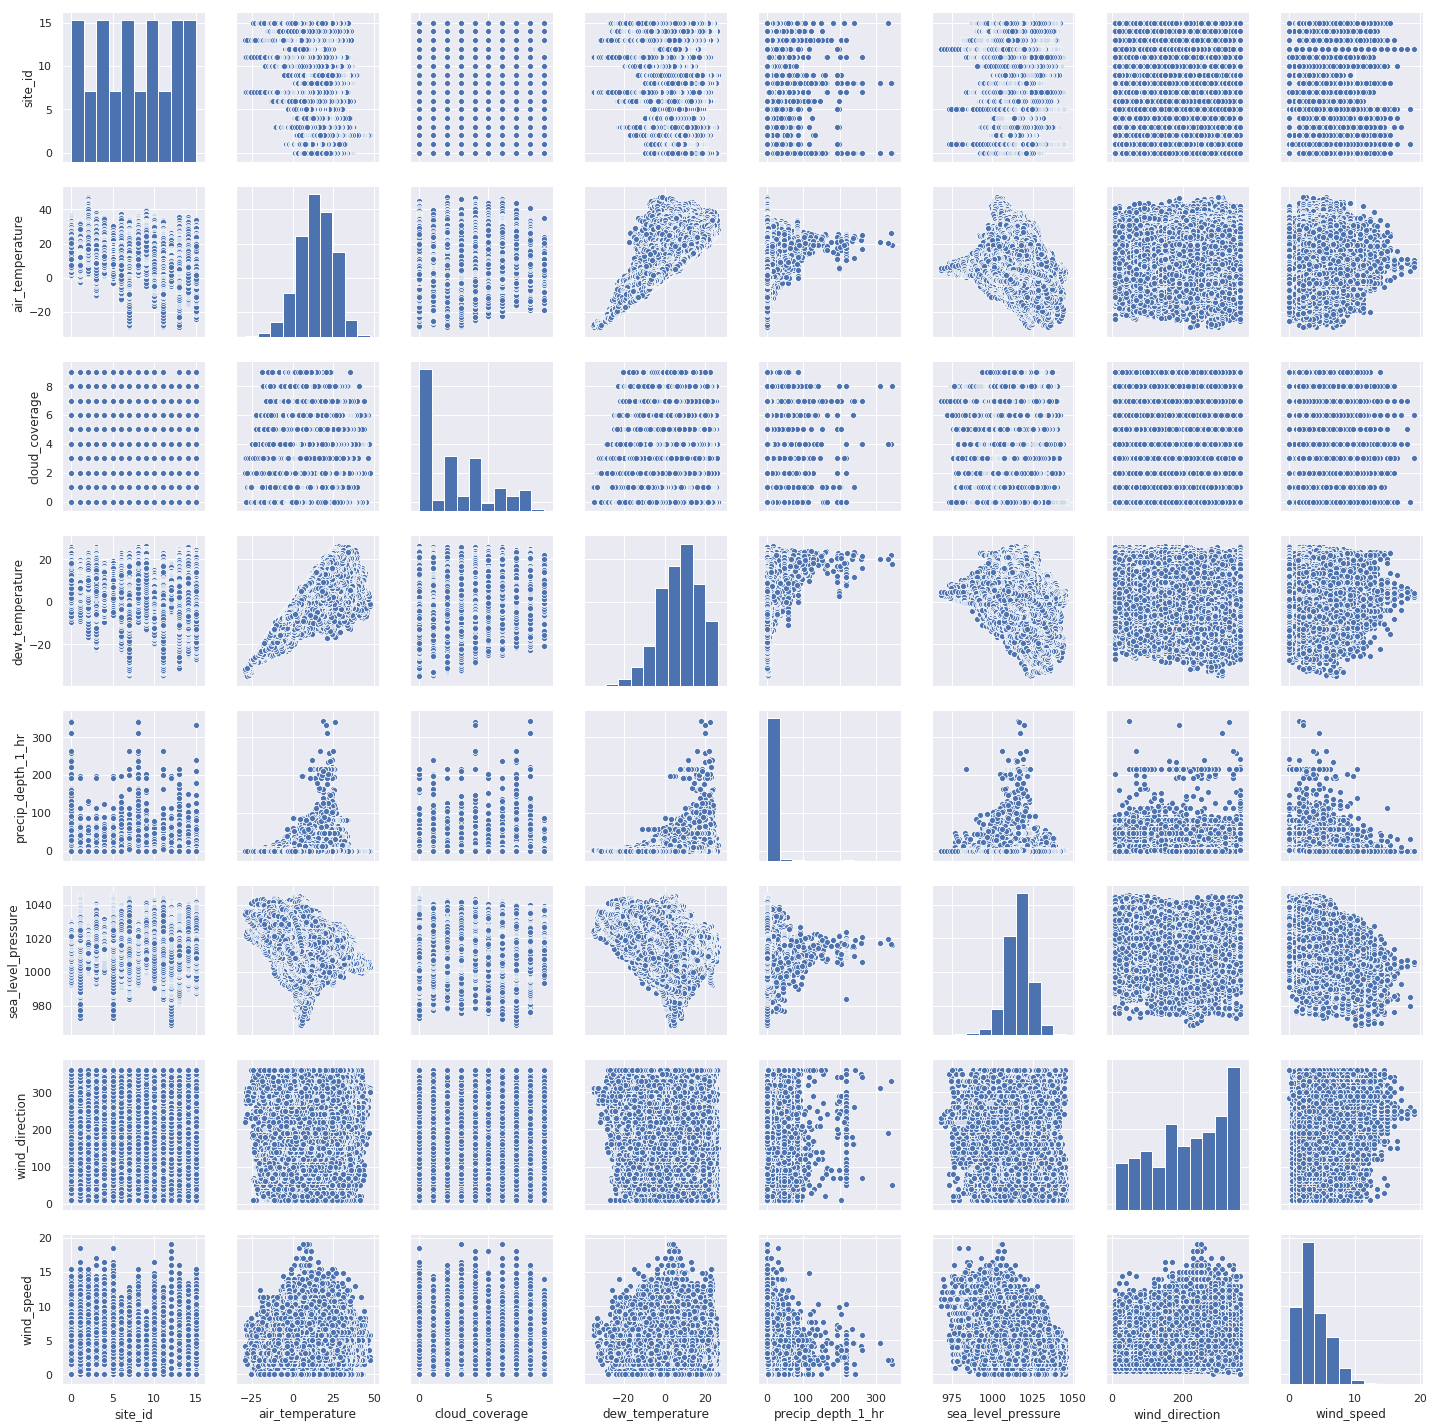

In [31]:
sns.pairplot(weather)

##### Visualize by site

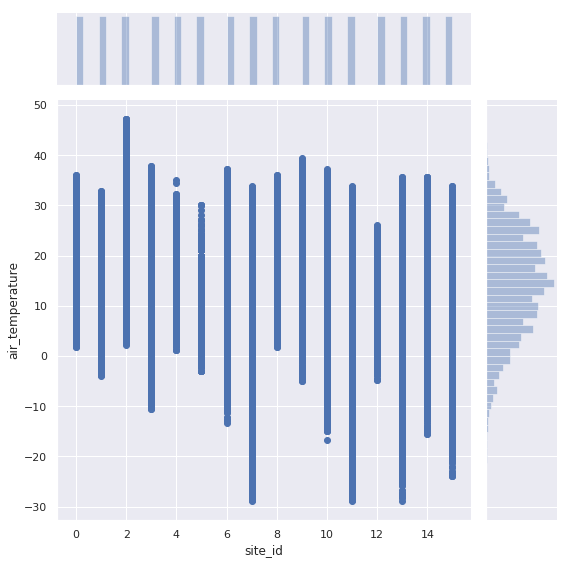

In [32]:
sns.jointplot('site_id', 'air_temperature', data=weather, height=8)

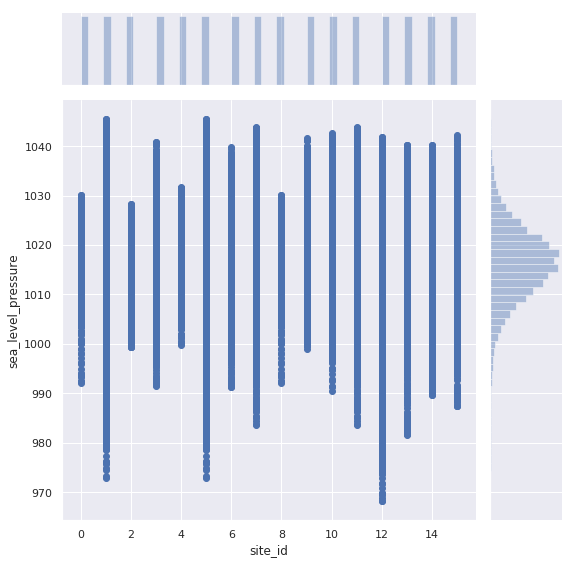

In [33]:
sns.jointplot('site_id', 'sea_level_pressure', data=weather, height=8)

These plots support the following claims made during the cleaning process:
- Sites 1, 5, and 12 are near each other
- Sites 7, 11, and 15 are near each other in a colder region
    - Site 13 may also be near these 3 sites

<Figure size 1152x432 with 0 Axes>

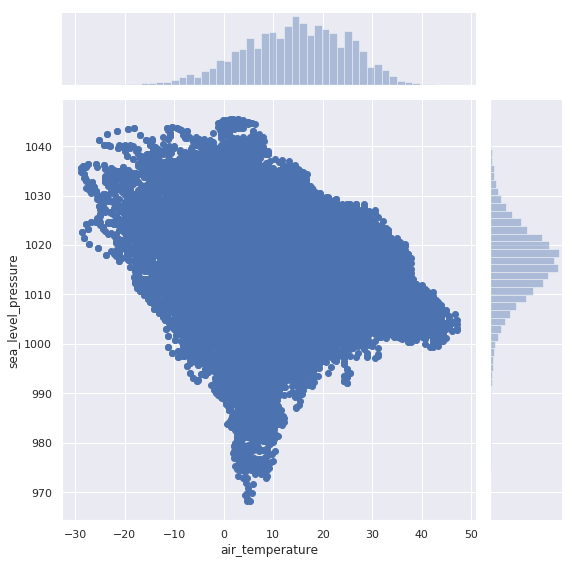

In [34]:
fig = plt.figure(figsize=(16, 6))
sns.jointplot('air_temperature', 'sea_level_pressure', data=weather, height=8)

<Figure size 1152x432 with 0 Axes>

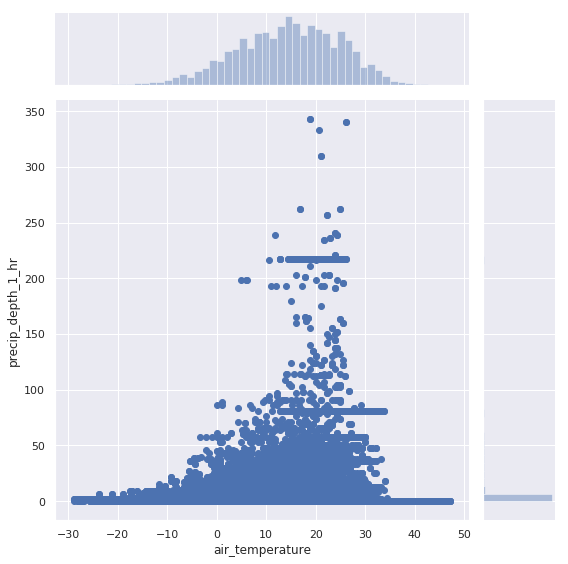

In [35]:
fig = plt.figure(figsize=(16, 6))
sns.jointplot('air_temperature', 'precip_depth_1_hr', data=weather, height=8)

In [36]:
del fig
gc.collect()

142

Observations:
- `air_temperature` and `sea_level_pressure` are normally distributed
- The highest and lowest `sea_level_pressure` both occur at an `air_temperature` of about 5 degrees Celsius
- At the coldest `air_temperature`s, the `sea_level_pressure` is generally higher
- At the hottest `air_temperature`s, the `sea_level_pressure` is about 1005 mbar
- The most rain occurs at `air_temperature`s of around 5 to 25 degrees Celsius

##### Time series analysis

In [37]:
# Extract 1 site and downsample to daily frequency
wthr0_day = weather[weather.site_id == 0].drop('site_id', axis=1).set_index('timestamp').resample('d').mean()
wthr0_day.head()

air_temperature  cloud_coverage  dew_temperature  \
timestamp                                                      
2016-01-01        23.337500        5.333333        20.020834   
2016-01-02        19.537500        6.041667        15.325000   
2016-01-03        14.829166        8.000000        12.479167   
2016-01-04        12.666667        4.458333         4.429167   
2016-01-05        14.058333        2.541667         7.066667   

            precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  
timestamp                                                                      
2016-01-01           0.002083         1018.960938      272.916667    1.854167  
2016-01-02           0.000833         1018.966187      167.500000    3.925000  
2016-01-03           0.794583         1017.241638      276.666667    5.000000  
2016-01-04           0.750833         1015.647461      318.333333    4.283333  
2016-01-05           0.000000         1022.370850      142.083333    6.258333

(array([16801, 16832, 16861, 16892, 16922, 16953, 16983, 17014, 17045,
        17075, 17106, 17136, 17166]), <a list of 13 Text xticklabel objects>)

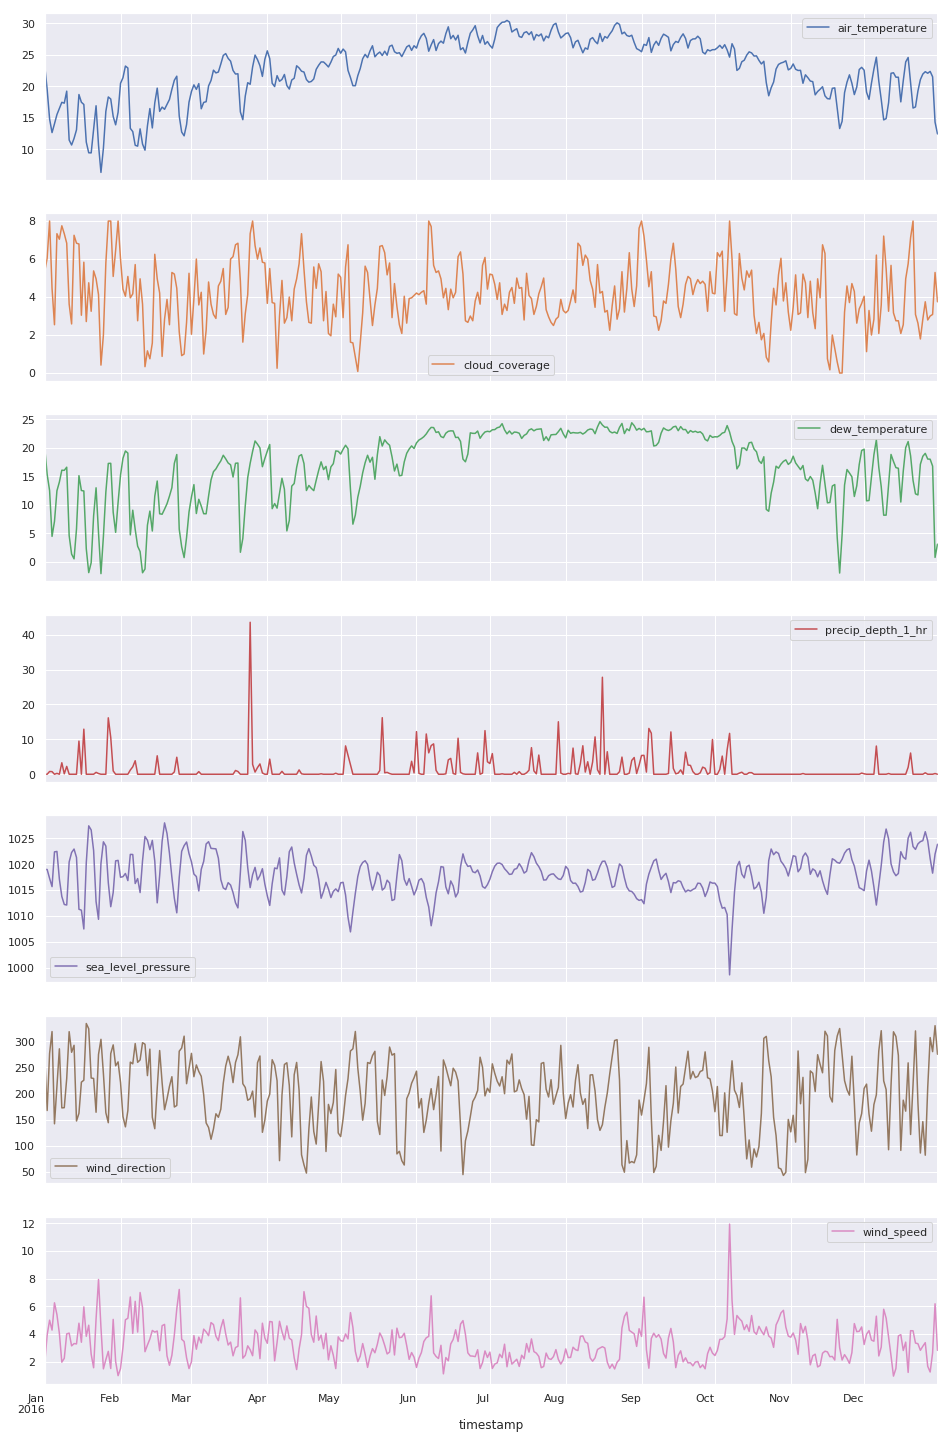

In [38]:
# Daily weather in site 0
wthr0_day.plot(subplots=True, figsize=(16, 28))
plt.xticks(rotation=0)

In [39]:
del wthr0_day

Observations:
- As expected, there is a rise in temperature around summertime
- The oscillations in `cloud_coverage` and `wind_direction` have a lower amplitude (wave height) during the summer months
- A lot of rain is seen at the end of March and in the middle of August
- The deepest dip in `sea_level_pressure` occurs at approximately the same time as the highest peak in `wind_speed`

In [40]:
# Extract hour from timestamp
weather['hour'] = weather.timestamp.dt.hour

# Site 4 hourly weather
wthr4 = weather[weather.site_id == 4].drop('site_id', axis=1)
wthr4_byhr = wthr4.groupby('hour').mean()

wthr4_byhr

air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
hour                                                                        
0           18.429235        2.587432        10.295629           0.376257   
1           17.559017        2.617486        10.228142           0.370847   
2           16.497814        2.587432        10.210110           0.324317   
3           15.537705        2.532787        10.153278           0.253197   
4           14.852733        2.461749        10.144262           0.275027   
5           14.421311        2.316940        10.099727           0.179426   
6           14.056830        2.240437        10.018306           0.182377   
7           13.726230        2.133880         9.959563           0.357158   
8           13.477595        2.054645         9.864481           0.280601   
9           13.225956        2.008197         9.719398           0.392650   
10          13.005737        2.071038         9.583607           0.114044   
11          12.836612        2.019126         9.484153           0.116776   
12          12.570765        2.087432         9.301366           0.103142   
13          12.376503        2.251366         9.248088           0.357131   
14          12.464208        2.366120         9.267487           0.373661   
15          12.968852        2.497268         9.444263           0.398388   
16          14.024863        2.543716         9.832139           0.365383   
17          15.154371        2.546448        10.150546           0.212404   
18          16.210655        2.500000        10.147541           0.168716   
19          17.238525        2.456284        10.051879           0.272459   
20          18.124863        2.409836         9.994263           0.070246   
21          18.772678        2.475410        10.024317           0.258716   
22          19.107103        2.521858        10.073771           0.215137   
23          19.016666        2.565574        10.167486           0.234180   

      sea_level_pressure  wind_direction  wind_speed  
hour                                                  
0            1016.129333      266.748634    5.947268  
1            1016.019714      266.188525    5.579782  
2            1016.091248      267.745902    5.095082  
3            1016.290588      265.491803    4.547267  
4            1016.573486      269.316940    4.071858  
5            1016.859009      267.745902    3.654645  
6            1016.994934      263.852459    3.403005  
7            1016.981750      260.983607    3.117213  
8            1016.929382      255.136612    3.054372  
9            1016.787415      242.841530    3.013934  
10           1016.684998      243.633880    2.960929  
11           1016.601562      239.565574    2.848361  
12           1016.558044      228.207650    2.635519  
13           1016.686462      218.286885    2.616120  
14           1016.958679      228.784153    2.683060  
15           1017.301270      234.467213    2.657650  
16           1017.619629      241.229508    2.749454  
17           1017.851440      234.781421    3.201366  
18           1017.991394      232.404372    3.548361  
19           1017.897095      243.784153    3.891257  
20           1017.478088      252.459016    4.604918  
21           1016.975708      257.322404    5.186066  
22           1016.556580      262.786885    5.649454  
23           1016.272949      263.374317    5.878415

([<matplotlib.axis.XTick at 0x7f940b305780>,
 <a list of 24 Text xticklabel objects>)

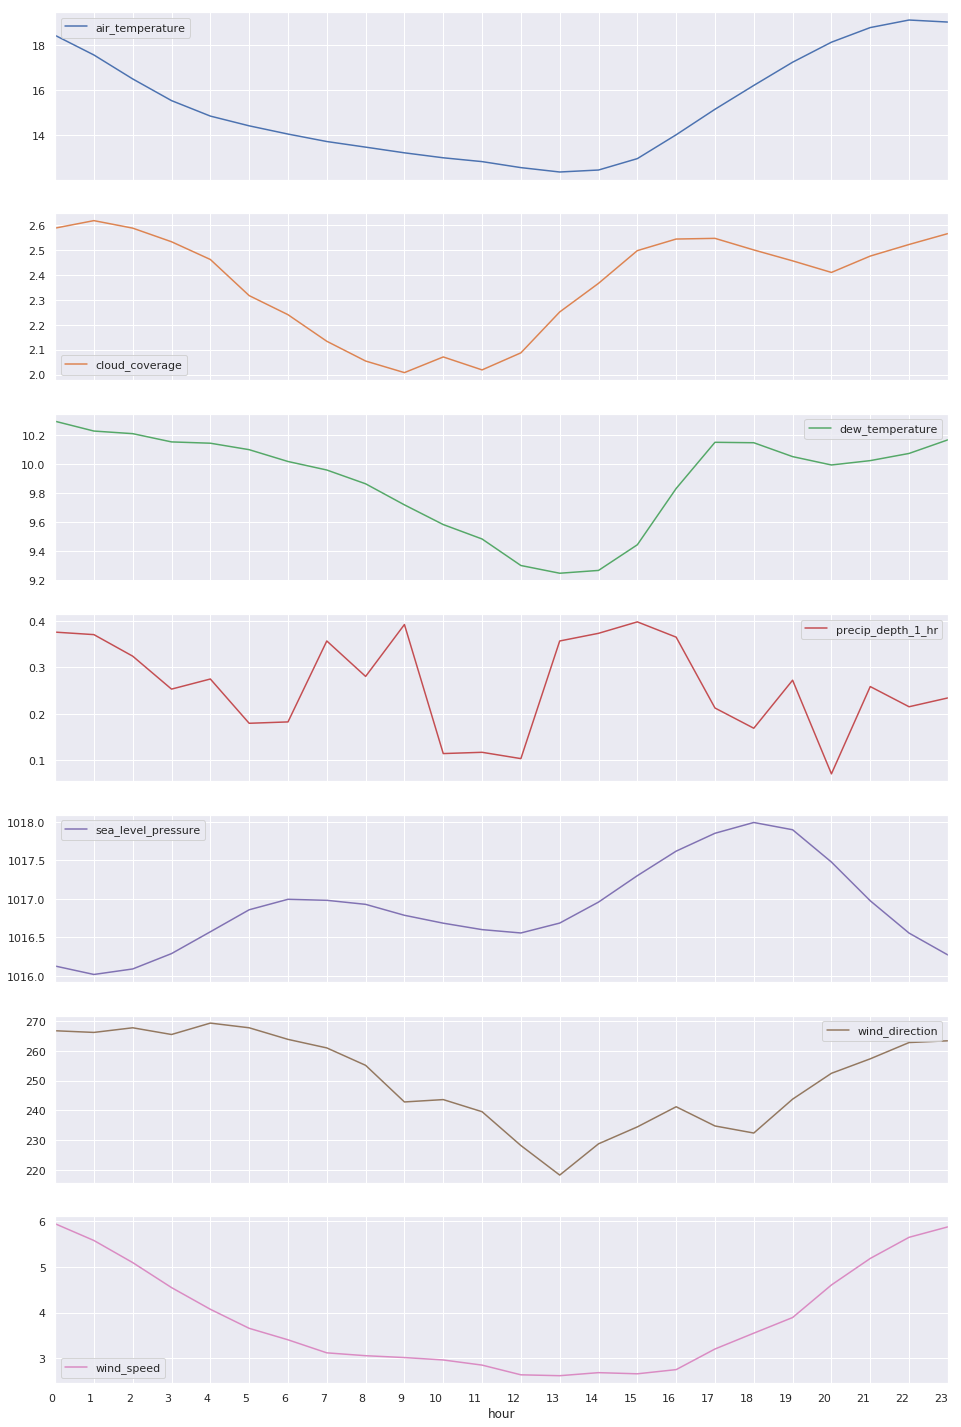

In [ ]:
# Hourly weather of site 4 averaged across everyday in 2016
wthr4_byhr.plot(subplots=True, figsize=(16,28))
plt.xticks(range(24), rotation=0)

The temperature here doesn't look quite right. According to the `air_temperature` subplot, the temperature at this site is at the daily high at around 10 PM. There may be an error with the data.

##### Check the average hourly `air_temperature` at every site

In [ ]:
# Average hourly air temperature by site
airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')
airtemp

site_id         0          1          2          3          4          5   \
hour                                                                        
0        23.481148  10.001579  30.238525  16.589077  18.429235   9.669505   
1        22.490711   9.690836  29.461203  15.855423  17.559017   9.498009   
2        21.805464   9.438734  28.376053  15.239617  16.497814   9.357673   
3        21.277596   9.190984  27.166666  14.760608  15.537705   9.227823   
4        20.880054   9.017213  26.021038  14.364207  14.852733   9.100926   
5        20.408743   9.005191  24.926777  13.959352  14.421311   9.078324   
6        20.083059   9.263934  23.953552  13.655741  14.056830   9.201248   
7        19.730328   9.804645  23.201094  13.265697  13.726230   9.571202   
8        19.445263  10.562518  22.425957  12.994809  13.477595  10.093286   
9        19.265450  11.518579  21.620218  12.686066  13.225956  10.786885   
10       19.094851  12.520219  20.950274  12.393716  13.005737  11.510929   
11       19.113115  13.400620  20.350821  12.455738  12.836612  12.097160   
12       19.631695  14.103064  19.831694  12.917213  12.570765  12.565810   
13       21.205465  14.506161  19.415028  13.796994  12.376503  12.931075   
14       23.064207  14.849725  19.621311  14.863388  12.464208  13.081967   
15       24.689344  14.761679  20.757103  16.008196  12.968852  13.016086   
16       25.924591  14.430512  22.664480  17.064482  14.024863  12.740669   
17       26.713934  13.897540  24.577595  18.035519  15.154371  12.341593   
18       27.208197  13.310298  26.236612  18.787704  16.210655  11.854065   
19       27.518579  12.635965  27.619398  19.104372  17.238525  11.338405   
20       27.324043  12.026411  28.775682  19.199682  18.124863  10.789851   
21       26.818033  11.472677  29.677103  18.942034  18.772678  10.421255   
22       26.032515  10.980328  30.246449  18.249180  19.107103  10.196721   
23       24.760656  10.432116  30.457376  17.451639  19.016666   9.959180   

site_id         6          7          8          9          10         11  \
hour                                                                        
0        16.328962   9.239038  23.481148  24.332787  15.720219   9.239038   
1        15.329782   8.289638  22.490711  23.072620  14.725683   8.289638   
2        14.601912   7.553571  21.805464  21.981222  13.554645   7.553571   
3        13.974317   6.997800  21.277596  21.131147  12.117535   6.997800   
4        13.442349   6.476724  20.880054  20.340630  11.005112   6.476724   
5        13.037978   6.013010  20.408743  19.635519  10.353354   6.013010   
6        12.551912   5.619685  20.083059  19.121038   9.833760   5.619685   
7        12.207707   5.200534  19.730328  18.687979   9.360452   5.200534   
8        11.886603   4.802525  19.445263  18.307924   8.954655   4.802525   
9        11.601316   4.461576  19.265450  17.986612   8.584316   4.461576   
10       11.265932   4.225305  19.094851  17.731968   8.189239   4.225305   
11       11.200684   4.581613  19.113115  17.533607   7.815240   4.581613   
12       11.734354   5.306109  19.631695  17.354372   7.463052   5.306109   
13       13.000000   6.118958  21.205465  17.499454   7.320840   6.118958   
14       14.627758   7.141798  23.064207  18.521585   8.018605   7.141798   
15       16.134378   8.220030  24.689344  20.142897   9.376229   8.220030   
16       17.419399   9.170306  25.924591  21.760109  11.077377   9.170306   
17       18.366667   9.953102  26.713934  23.283607  12.718033   9.953102   
18       19.145796  10.603958  27.208197  24.468330  14.056284  10.603958   
19       19.623224  10.998811  27.518579  25.453005  15.004800  10.998811   
20       19.776554  11.150941  27.324043  26.143089  15.646995  11.150941   
21       19.538927  11.144646  26.818033  26.395901  16.086338  11.144646   
22       18.724318  10.739876  26.032515  26.263231  16.366940  10.739876   
23       17.614754  10.048343  24.760656  25.557104  16.327362  10.04834

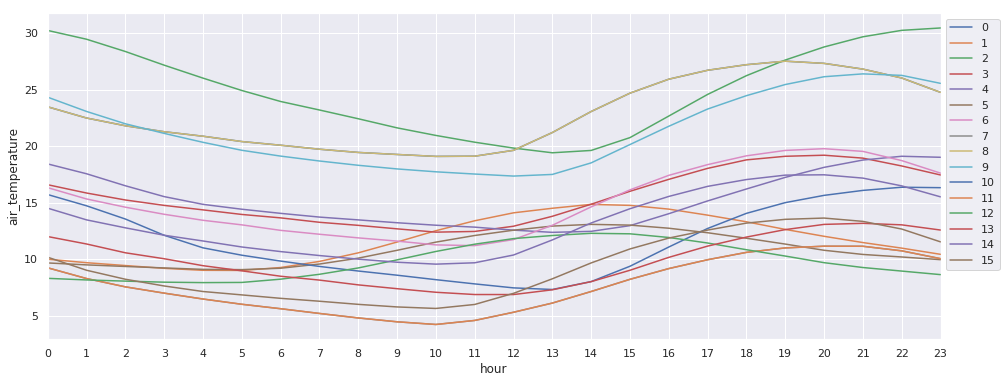

In [ ]:
airtemp.plot(figsize=(16, 6), xticks=range(24))
plt.ylabel('air_temperature')
plt.legend(bbox_to_anchor=(1, 1))

This is not right at all. In many of the sites, the temperature is reaching its peak at night time hours and found at the daily low at morning to afternoon hours. This means the timestamps were most likely recorded in UTC (GMT).

This makes the problem more complicated but it does give some information. It supports the earlier claims that sites 1, 5, and 12 are nearby as they are in the same time zone. There is also support for sites 7, 11, and 15 also being in the nearby. Many other sites look like they are in the same time zone as sites 7, 11, and 15 too, so they may also be nearby. These claims are not definitive but there is a lot of information to support them.

In order to make better sense of the weather data, these timestamps will have to be converted to local time.

Thanks to the work of several Kagglers, most of the sites have been identified. The exact location of some of the sites are uncertain but the location has been narrowed down enough to determine the timezone for all sites. The locations and timezone of each site are as follows:
0. Orlando, Florida (GMT-5)
1. United Kingdom (GMT+0)
2. Arizona (GMT-7)
3. U.S. Eastern Time Zone (GMT-5)
4. Northern California (GMT-8)
5. United Kingdom (GMT+0)
6. U.S. Eastern Time Zone (GMT-5)
7. Southeastern Canada (GMT-5)
8. Orlando, Florida (GMT-5)
9. Texas (GMT-6)
10. U.S. Mountain Time Zone (GMT-7)
11. Southeastern Canada (GMT-5)
12. Dublin, Ireland (GMT+0)
13. Minnesota (GMT-6)
14. U.S. Eastern Time Zone (GMT-5)
15. U.S. Eastern Time Zone (GMT-5)

All the credit goes to Kaggle users: `poedator`, `patrick0302`, and `datadugong`.

Sources:
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698
- https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature
- https://www.kaggle.com/datadugong/locate-better-cities-by-weather-temp-fill-nans

##### Convert all the timestamps to local time

In [ ]:
# List of timezone offsets for each site
# timezone = {0:-4, 1:0, 2:-7, 3:-4, 4:-7, 5:0, 6:-4, 7:-4, 8:-4, 9:-5, 10:-7, 11:-4, 12:0, 13:-5, 14:-4, 15:-4}
timezone = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]

# Offsets based on site
offset = weather.site_id.apply(lambda s: pd.offsets.Hour(timezone[s]))

# Adjust the timestamps and hours
weather.timestamp += offset
weather['hour'] = weather.timestamp.dt.hour

weather.head()

/home/tri/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py:1151: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  PerformanceWarning,


site_id           timestamp  air_temperature  cloud_coverage  \
0        0 2015-12-31 19:00:00        25.000000               6   
1        0 2015-12-31 20:00:00        24.400000               4   
2        0 2015-12-31 21:00:00        22.799999               2   
3        0 2015-12-31 22:00:00        21.100000               2   
4        0 2015-12-31 23:00:00        20.000000               2   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0               0.01         1019.700012             360   
1             21.1               0.01         1020.200012              70   
2             21.1               0.00         1020.200012             360   
3             20.6               0.00         1020.099976             360   
4             20.0               0.01         1020.000000             250   

   wind_speed  hour  
0         0.0    19  
1         1.5    20  
2         0.0    21  
3         0.0    22  
4         2.6    23

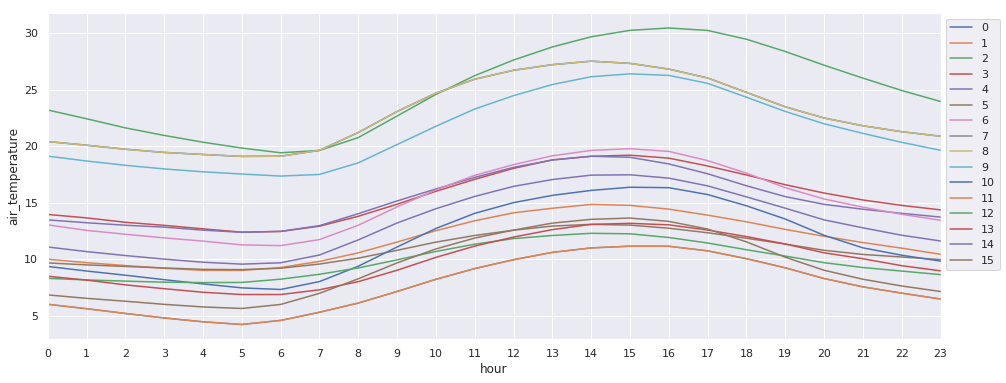

In [ ]:
# Replot average hourly air temperature by site
airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')
airtemp.plot(figsize=(16, 6), xticks=range(24))
plt.ylabel('air_temperature')
plt.legend(bbox_to_anchor=(1, 1))

Now the temperature data makes a lot more sense. They don't line up exactly but that may be because the temperature peaks at different times at each location.

Due to this offset, the data now contains a few hours from 2015 and is missing a few hours at the end of 2016 at most sites.

##### Reindex the weather data to include every hour in 2016 and use forward fill to fill the data for the missing hours

In [ ]:
weather.set_index(['site_id', 'timestamp'], inplace=True)

weather = weather.reindex(
    pd.MultiIndex.from_product([
        building.site_id.unique(), 
        pd.date_range(start='1/1/2016 00:00:00', end='12/31/2016 23:00:00', freq='H')
    ])
)

weather.index.rename(['site_id', 'timestamp'], inplace=True)
weather.reset_index(inplace=True)

weather.head()

site_id           timestamp  air_temperature  cloud_coverage  \
0        0 2016-01-01 00:00:00             19.4             4.0   
1        0 2016-01-01 01:00:00             21.1             6.0   
2        0 2016-01-01 02:00:00             21.1             6.0   
3        0 2016-01-01 03:00:00             20.6             6.0   
4        0 2016-01-01 04:00:00             21.1             6.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             19.4               0.00         1019.762939           360.0   
1             21.1               0.01         1019.400024           360.0   
2             21.1               0.00         1018.799988           210.0   
3             20.0               0.00         1018.099976           360.0   
4             20.6               0.00         1019.000000           290.0   

   wind_speed  hour  
0         0.0   0.0  
1         0.0   1.0  
2         1.5   2.0  
3         0.0   3.0  
4         1.5   4.0

In [ ]:
weather['hour'] = weather.timestamp.dt.hour
weather = weather.fillna(method='ffill')
weather.tail(10)

site_id           timestamp  air_temperature  cloud_coverage  \
140534       15 2016-12-31 14:00:00              3.0             1.0   
140535       15 2016-12-31 15:00:00              2.8             2.0   
140536       15 2016-12-31 16:00:00              2.8             2.0   
140537       15 2016-12-31 17:00:00              2.2             2.0   
140538       15 2016-12-31 18:00:00              1.7             2.0   
140539       15 2016-12-31 19:00:00              1.7             2.0   
140540       15 2016-12-31 20:00:00              1.7             2.0   
140541       15 2016-12-31 21:00:00              1.7             2.0   
140542       15 2016-12-31 22:00:00              1.7             2.0   
140543       15 2016-12-31 23:00:00              1.7             2.0   

        dew_temperature  precip_depth_1_hr  sea_level_pressure  \
140534             -8.0               0.01         1007.320374   
140535             -8.9               0.01         1007.400024   
140536             -7.2               0.01         1007.500000   
140537             -6.7               0.01         1008.000000   
140538             -5.6               0.01         1008.500000   
140539             -5.6               0.01         1008.500000   
140540             -5.6               0.01         1008.500000   
140541             -5.6               0.01         1008.500000   
140542             -5.6               0.01         1008.500000   
140543             -5.6               0.01         1008.500000   

        wind_direction  wind_speed  hour  
140534           180.0         5.7    14  
140535           180.0         7.7    15  
140536           180.0         5.1    16  
140537           170.0         4.6    17  
140538           180.0         8.8    18  
140539           180.0         8.8    19  
140540           180.0         8.8    20  
140541           180.0         8.8    21  
140542           180.0         8.8    22  
140543           180.0         8.8    23

In [ ]:
del airtemp, timezone, offset, wthr4, wthr4_byhr
gc.collect()

107

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f941c8e1f98>,
      dtype=object)

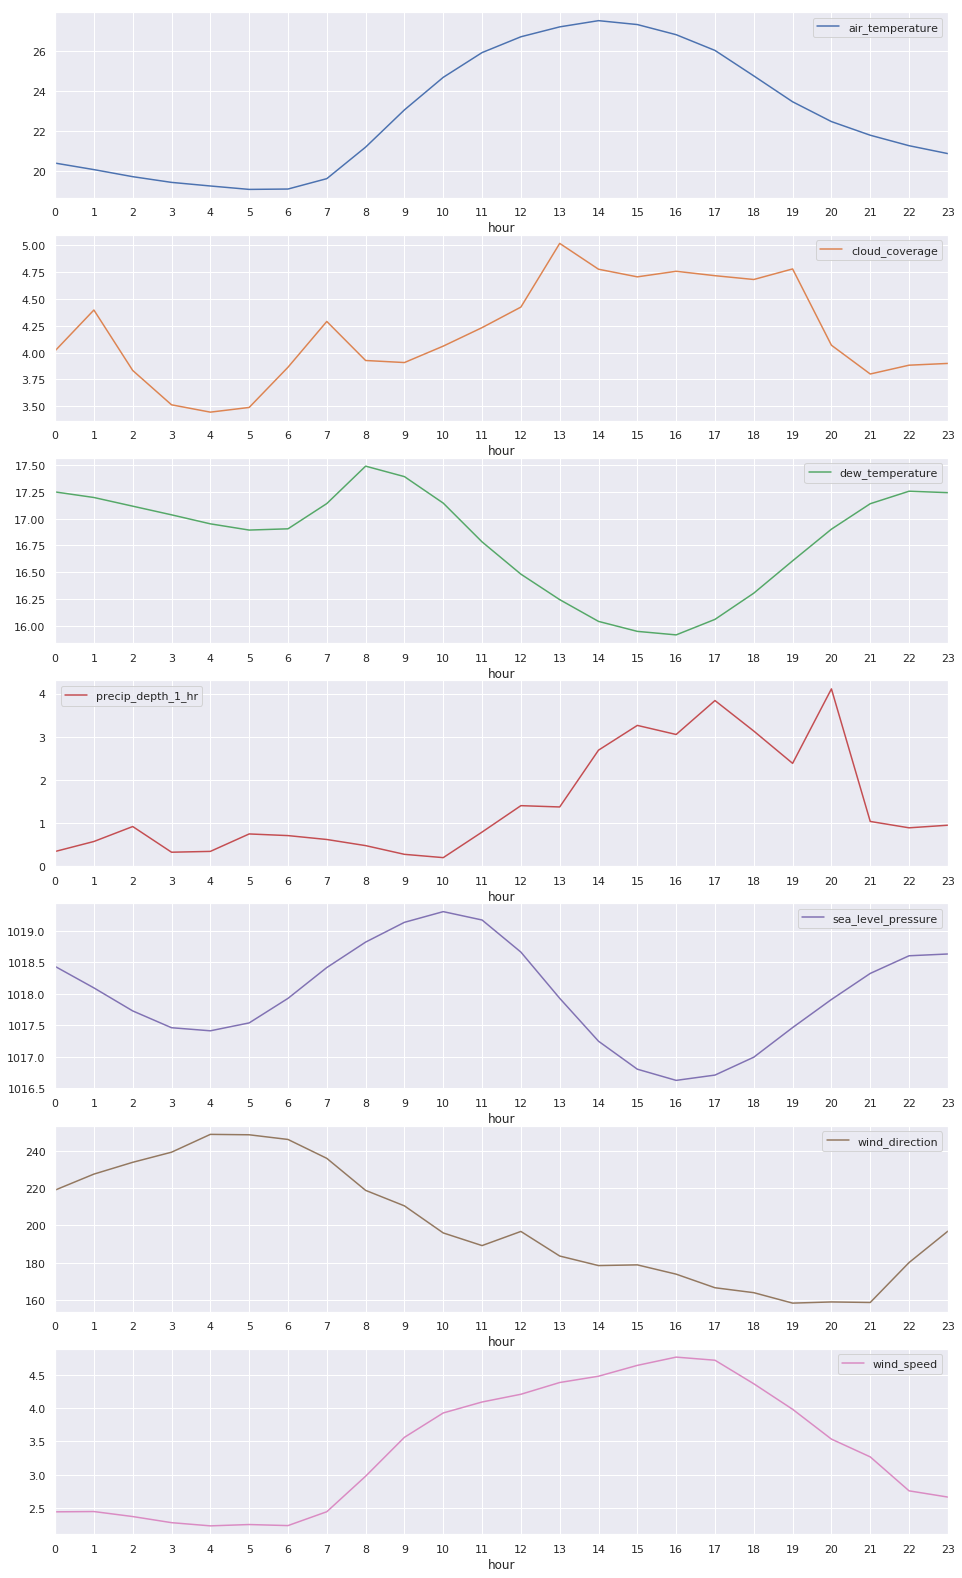

In [ ]:
# Site 8 hourly weather
wthr8 = weather[weather.site_id == 8].drop('site_id', axis=1)
wthr8_byhr = wthr8.groupby('hour').mean()

# Hourly weather of site 8 averaged across everyday in 2016
wthr8_byhr.plot(subplots=True, figsize=(16,28), sharex=False, xticks=range(24))

In [ ]:
del wthr8, wthr8_byhr
gc.collect()

67

In site 8 (on average):
- The `air_temperature` peaks at 2 PM (in the afternoon as it should)
- The `cloud_coverage` is highest between 1 and 7 PM
- The `dew_temperature` dips in the afternoon to evening, which makes sense because it is less humid during these hours
- On rainy days, it rains the most between 5 and 8 PM
- The `sea_level_pressure` oscillates throughout the day reaching its maximum at 10 AM and minimum at 4 PM
- The `wind_direction` is limited between 160 and 250 degrees, which is roughly in the south to southwest direction
- It gets the windiest around 4 PM

<a id='eda_meter'></a>
### Meter Analysis
[Back to 3. Exploratory Analysis](#eda)

##### Inspect the data

In [ ]:
meter.describe()

site_id   building_id         meter  meter_reading
count  2.021610e+07  2.021610e+07  2.021610e+07   2.021610e+07
mean   7.992232e+00  7.992780e+02  6.624412e-01   1.987455e+03
std    5.099060e+00  4.269133e+02  9.309921e-01   1.532159e+05
min    0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
25%    3.000000e+00  3.930000e+02  0.000000e+00   1.797590e+01
50%    9.000000e+00  8.950000e+02  0.000000e+00   7.509000e+01
75%    1.300000e+01  1.179000e+03  1.000000e+00   2.526000e+02
max    1.500000e+01  1.448000e+03  3.000000e+00   2.190470e+07

Although it was established that `timestamp`s for every hour in 2016 are present in the meter data, some buildings have more meters than others so these buildings would have more `timestamp`s. Some buildings may also be missing `timestamp`s.

##### Check the amount of `meter_reading`s for each building

Text(0, 0.5, 'Number of meter readings')

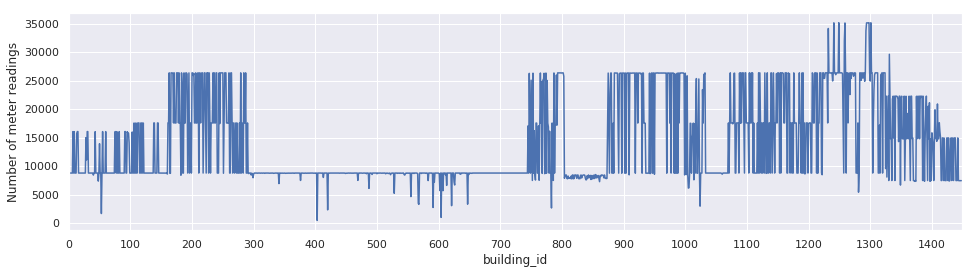

In [ ]:
# Number meter readings each building has
meter.groupby('building_id').timestamp.count().plot()
plt.xticks(range(0, 1500, 100))
plt.ylabel('Number of meter readings')

Text(0, 0.5, 'Number of meters')

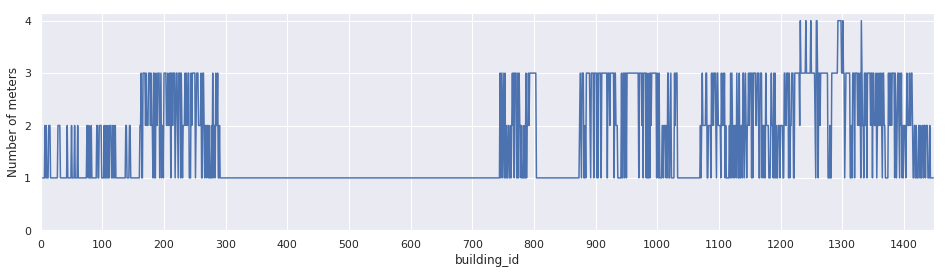

In [ ]:
# Number of meters each building has
metrct = meter.groupby('building_id').meter.nunique()

metrct.plot()
plt.xticks(range(0, 1500, 100))
plt.yticks(range(5))
plt.ylabel('Number of meters')

Text(0.5, 0, 'Number of buildings')

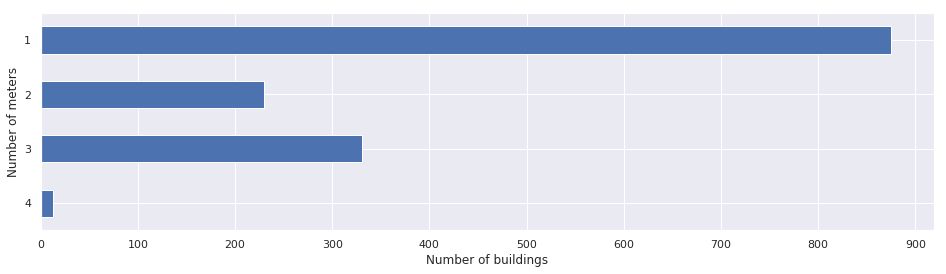

In [ ]:
# Number of buildings that have n amount of meters
metrct.value_counts().sort_index(ascending=False).plot(kind='barh')
plt.xticks(range(0, 1000, 100))
plt.ylabel('Number of meters')
plt.xlabel('Number of buildings')

Text(0.5, 0, 'Number of buildings')

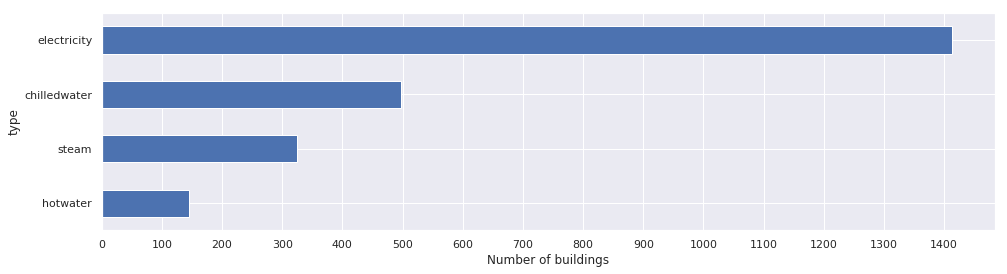

In [ ]:
# Number of buildings that have each meter type
bldgct_bymetr = meter.groupby('type').building_id.nunique().sort_values()
bldgct_bymetr.plot(kind='barh')
plt.yticks(range(4))
plt.xticks(range(0, 1500, 100))
plt.xlabel('Number of buildings')

In [ ]:
del metrct, bldgct_bymetr

Inferences:
- Most of the buildings only have 1 type of meter and very few buildings actually have all 4 meter `type`s
- Almost all the buildings have an electricity meter
- A lot of buildings don't have `meter_reading`s for every hour

##### Check the number of meters missing measurements

In [ ]:
bybldgmetr = meter.groupby(['building_id', 'meter']).count().reset_index()
metrct = bybldgmetr.meter.value_counts()
types = ['electricity', 'chilledwater', 'steam', 'hotwater']

# Missing meter readings
metrs_m = bybldgmetr[bybldgmetr.timestamp != 8784]
bldgs_m = metrs_m.building_id.nunique()
types_m = metrs_m.meter.value_counts()

print(f'A total of {metrs_m.shape[0]} meters ({metrs_m.shape[0] * 100 // bybldgmetr.shape[0]}%) are missing meter readings')
print(f'{bldgs_m} different buildings ({bldgs_m * 100 // bybldgmetr.building_id.nunique()}%) have meters that are missing meter readings\n')

for i in range(types_m.shape[0]):
    print(f'{types_m[i]} {types[i]} meters ({types_m[i] * 100 // metrct[i]}%) are missing meter readings')

A total of 1660 meters (69%) are missing meter readings
1085 different buildings (74%) have meters that are missing meter readings

990 electricity meters (70%) are missing meter readings
347 chilledwater meters (69%) are missing meter readings
221 steam meters (68%) are missing meter readings
102 hotwater meters (70%) are missing meter readings


In [ ]:
del bybldgmetr, metrct, types, metrs_m, bldgs_m, types_m, i
gc.collect()

129

Every meter should have 8784 recorded readings (24 hours x 366 days). The majority of meters is actually missing `meter_reading`s. This may not be a problem since there are about 20 million records in the meter data. For now, the meter data will be left as is, but this is something important to note.

##### Time series analysis

In [ ]:
bytime = meter.set_index('timestamp')
bytime.head()

site_id  building_id  meter         type  meter_reading
timestamp                                                          
2016-01-01        0            0      0  electricity            0.0
2016-01-01        0            1      0  electricity            0.0
2016-01-01        0            2      0  electricity            0.0
2016-01-01        0            3      0  electricity            0.0
2016-01-01        0            4      0  electricity            0.0

##### Begin with the buildings that opened in 2016 and 2017

In [ ]:
construct = building[building.in_construction == True]
construct

site_id  building_id                    primary_use  square_feet  \
28         0           28                         Office        52957   
45         0           45                         Retail        15304   
46         0           46                         Retail         9045   
99         0           99                         Office         2260   
103        0          103                      Education        21657   
363        3          363                      Education        69300   
409        3          409                      Education        38500   
567        4          567  Entertainment/public assembly        82670   

     year_built  floor_count  in_construction  
28         2016            2                1  
45         2016            1                1  
46         2016            1                1  
99         2016            1                1  
103        2016            1                1  
363        2017            3                1  
409        2016            2                1  
567        2016            4                1

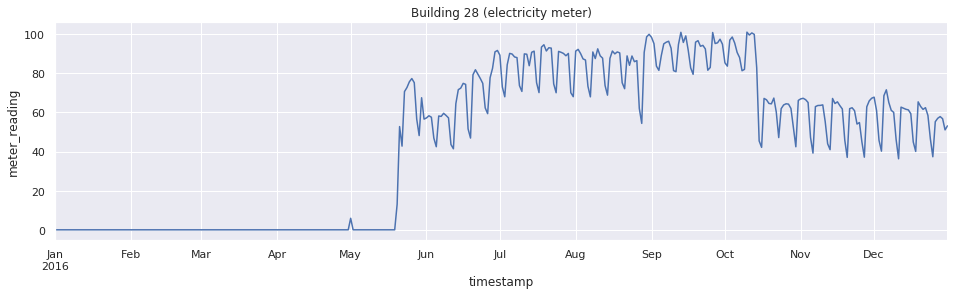

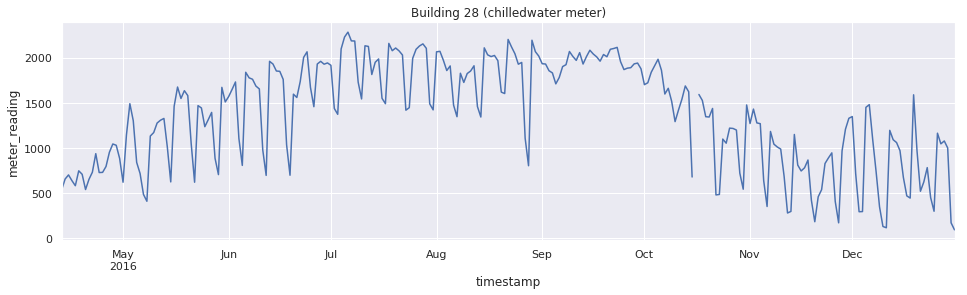

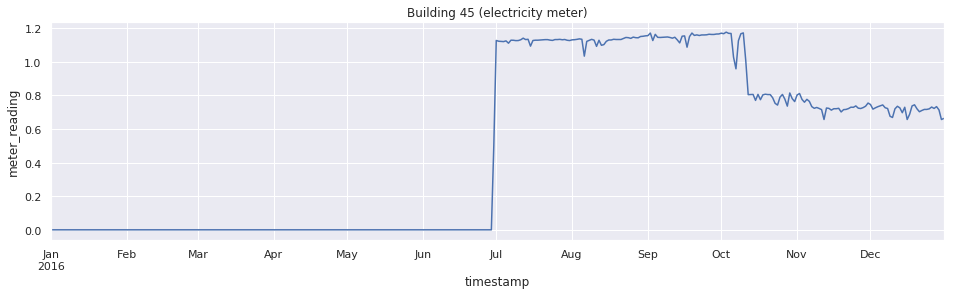

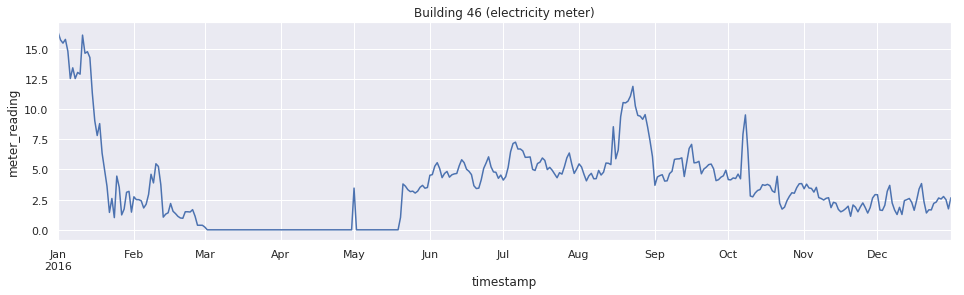

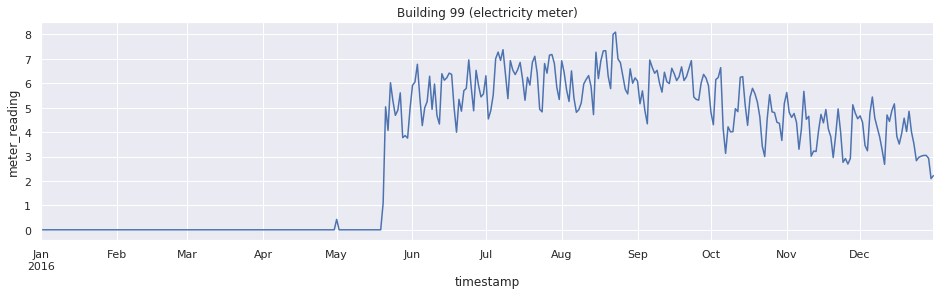

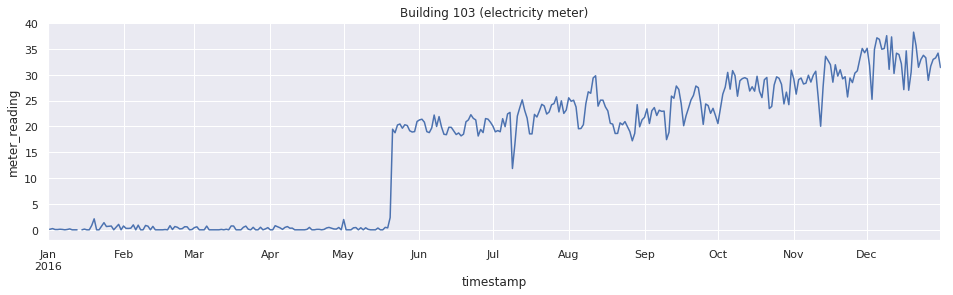

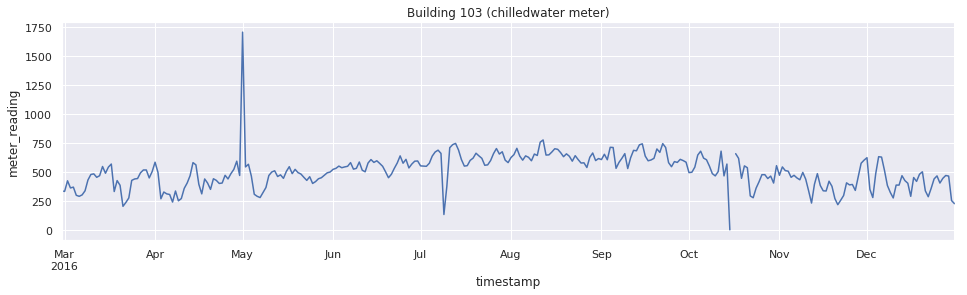

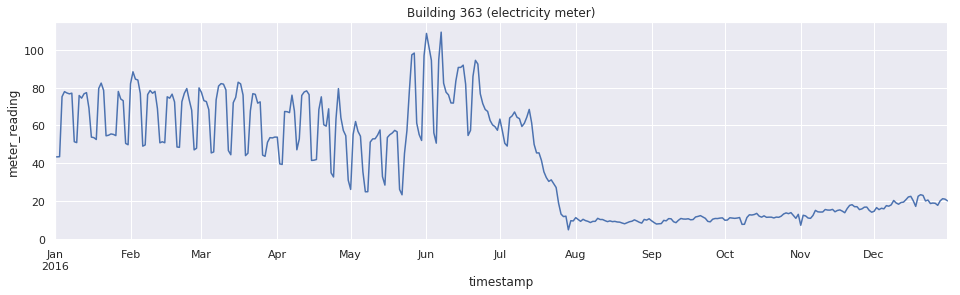

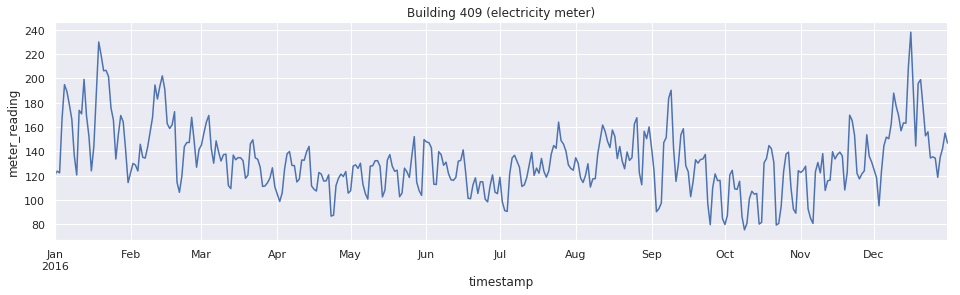

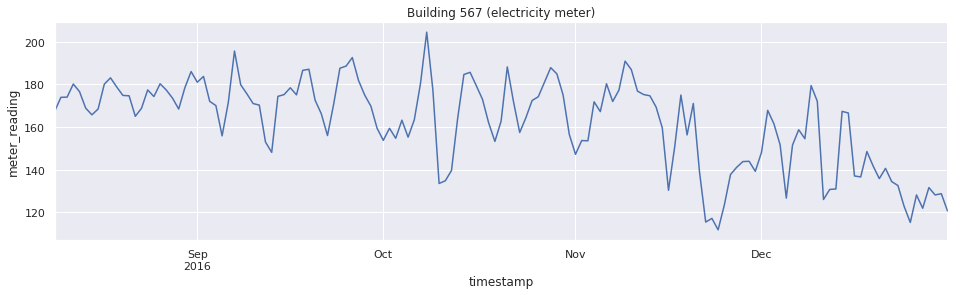

In [ ]:
for bldg in construct.building_id:
    for mtype in bytime[bytime.building_id == bldg].type.unique():
        fig = plt.figure(figsize=(16, 4))
        bytime[(bytime.building_id == bldg) & (bytime.type == mtype)].resample('d').mean().meter_reading.plot()
        plt.ylabel('meter_reading')
        plt.title(f'Building {bldg} ({mtype} meter)')

Electricity meters in the 2016/2017 buildings:
- All of these buildings have an electricity meter
- All the electricity meters from site 0 have a period of time stretching several months, where the meter readings stay around 0 (except for the outliers)
    - This could signify a period of non-operation or it could just be an error in data collection
- Buildings 28 and 45 show a similar drop in electricity usage in early to mid October, although there is a difference in scale
    - The scale difference (of about 100x) may mean the 2 buildings recorded the meter readings in different units
- Electricity usage in building 46 goes flat in March for 2 and a half months
- The electricity `meter_reading`s of buildings 45, 46, 99, and 103 are consistently low throughout the year
- Electricity usage in buildings 99 and 103 both increase from the 0 line in the middle of May
    - A possible explanation is that the 2 buildings are nearby and opened at the same time
- There's a big drop in electricity usage in building 363 in July and the usage stays relatively low for the rest of the year

Other inferences:
- The scale for chilled water `meter_reading`s are much higher than the scale for electricity `meter_reading`s
- The chilled water usage is higher in the summer months in building 28, but this pattern is not as apparent in building 103
- There are outliers (likely errors) with 4 meters that cause a peak in an otherwise flat section of the plot
- There are dips that deviate from the general usage pattern in a few meters
- Building 567 from site 4 is missing `meter_reading`s from the first 7 months

It may be best to just remove these 8 buildings from the data.

##### Remove all buildings that opened in either 2016 or 2017

In [ ]:
for bldg in construct.building_id:
    meter = meter[meter.building_id != bldg]
bytime = meter.set_index('timestamp')
bytime.shape

(20137746, 5)

In [ ]:
building.drop('in_construction', axis=1, inplace=True)
building.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432        2008            1
1        0            1   Education         2720        2004            1
2        0            2   Education         5376        1991            1
3        0            3   Education        23685        2002            1
4        0            4   Education       116607        1975            4

In [ ]:
del construct, bldg, mtype, fig
gc.collect()

48443

##### Plot the `meter_reading`s of each meter type by month

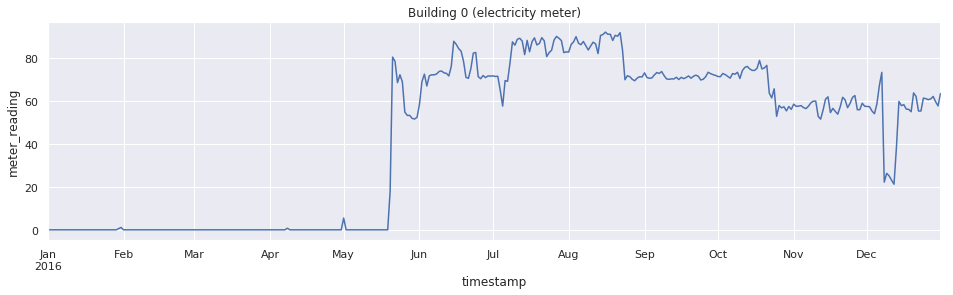

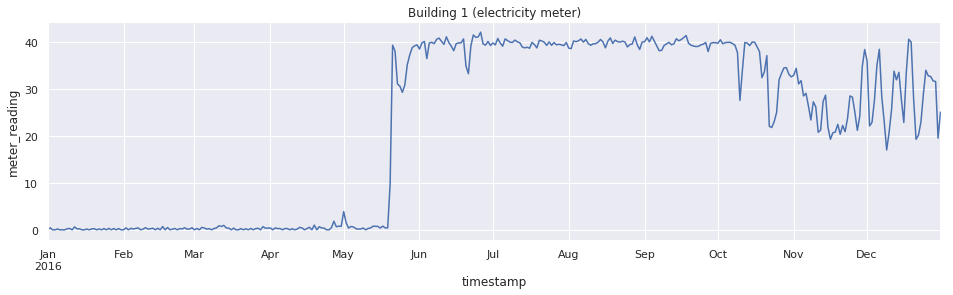

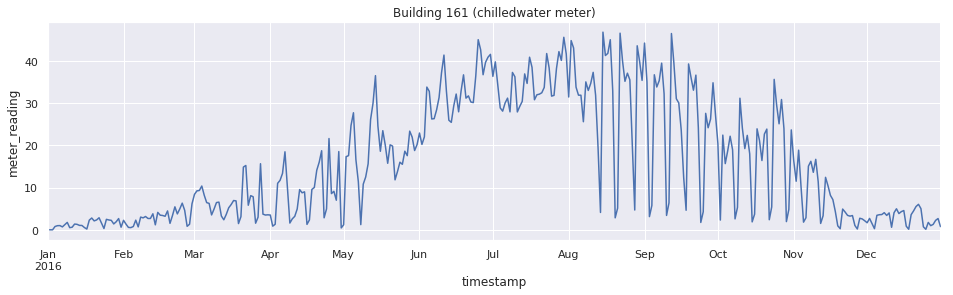

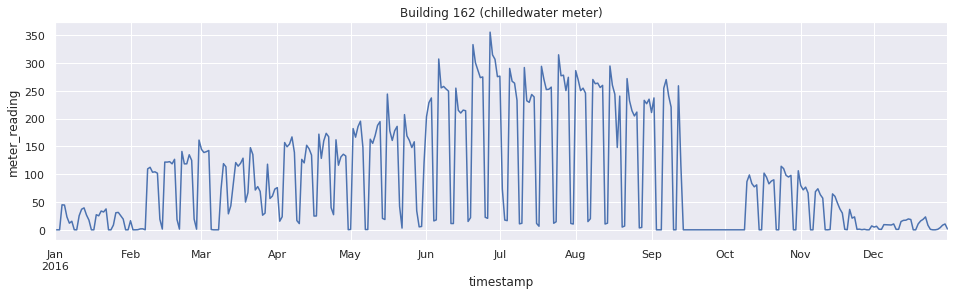

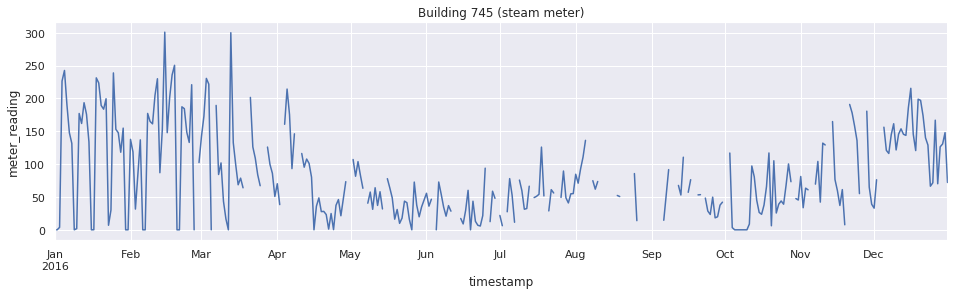

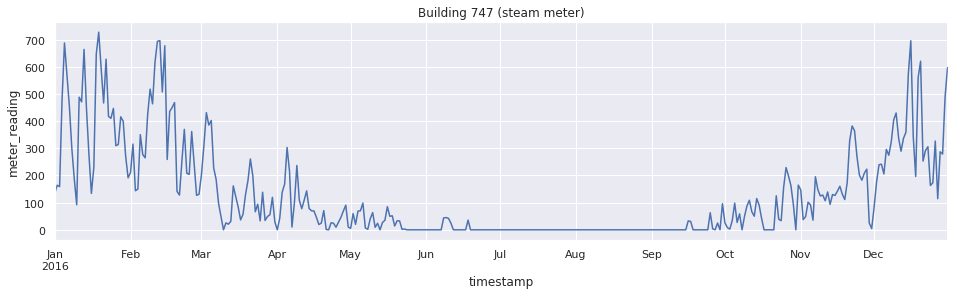

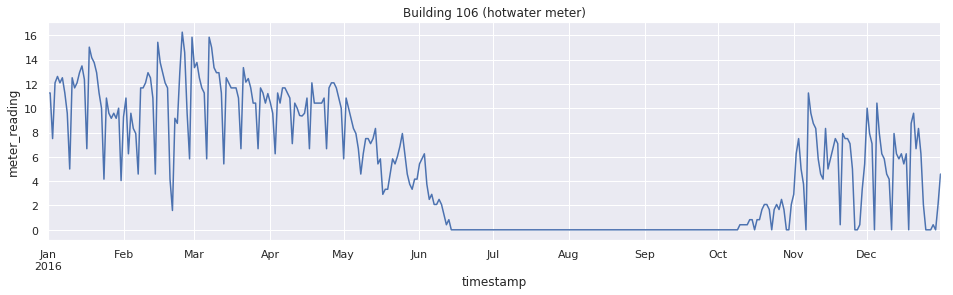

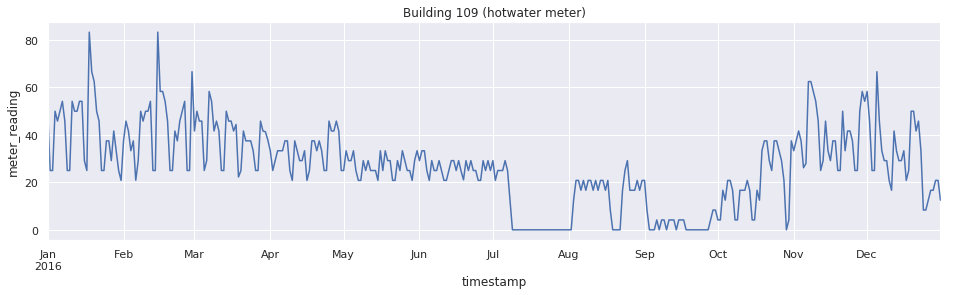

In [ ]:
# Locate each type of meter
metr_loc = {}
for mtype in range(4):
    metr_loc[mtype] = bytime[bytime.meter == mtype].building_id.unique()

# Meter types
types = ['electricity', 'chilledwater', 'steam', 'hotwater']

# Plot 2 of each
for mtype in metr_loc.keys():
    for bldg in metr_loc[mtype][:2]:
        fig = plt.figure(figsize=(16, 4))
        bytime[(bytime.building_id == bldg) & (bytime.meter == mtype)].resample('d').mean().meter_reading.plot()
        plt.ylabel('meter_reading')
        plt.title(f'Building {bldg} ({types[mtype]} meter)')

Electricity meters:
- Readings are at the 0 line from the beginning of the year to the middle of May
- Readings stay at a relatively constant level from mid-May to mid-October, where a slight drop occurs and again stays relatively constant for the rest of the year

Chilled water meters:
- Readings peak in the summer months as expected

Steam meters and hot water meters:
- Readings show the opposite pattern as chilled water meters (at the lowest in the summer months), which is also expected

There are also missing readings with some of these meters.

##### Plot the meter readings of each meter type by weekday

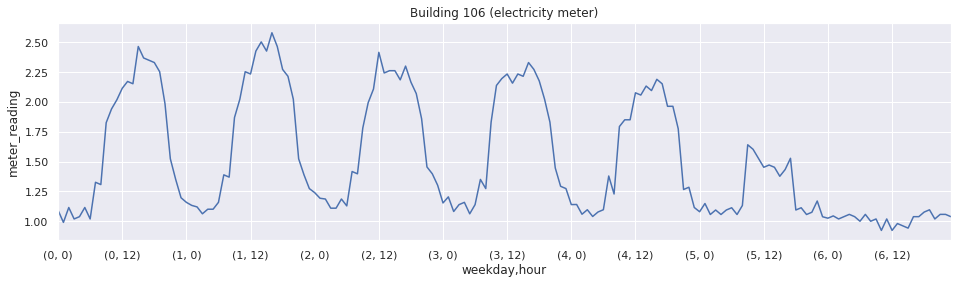

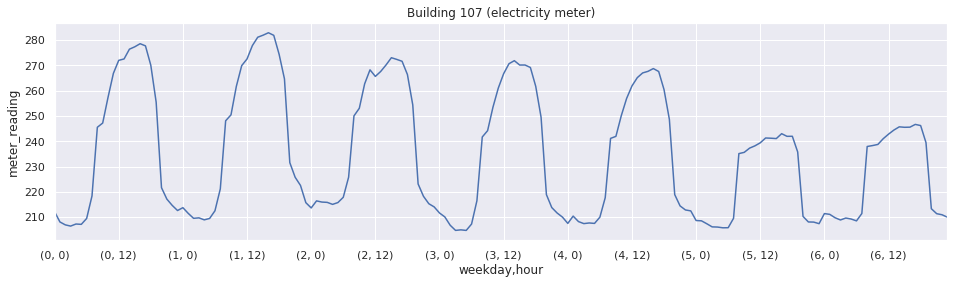

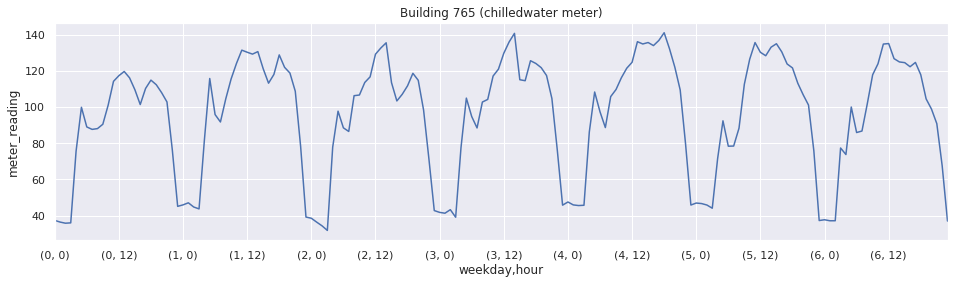

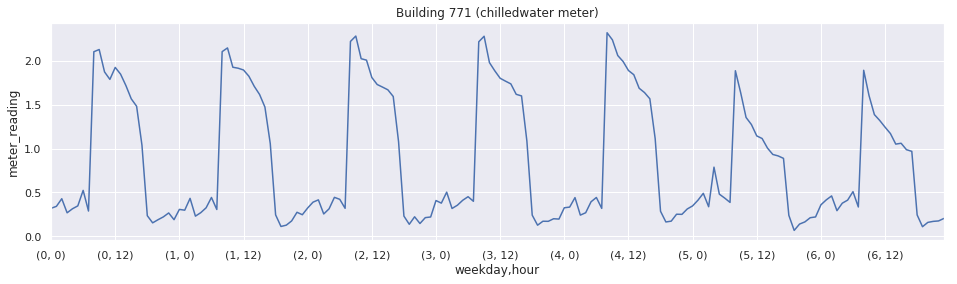

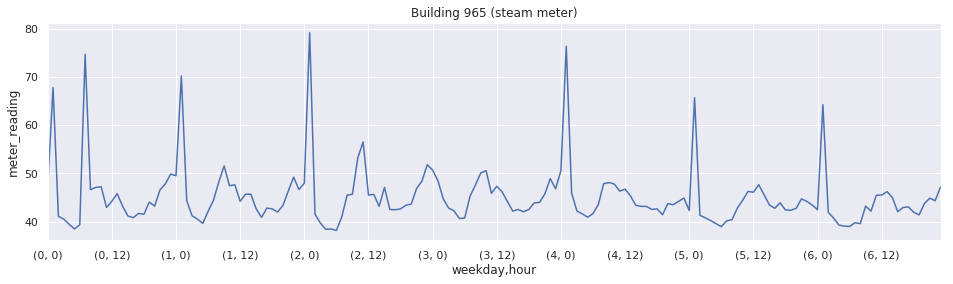

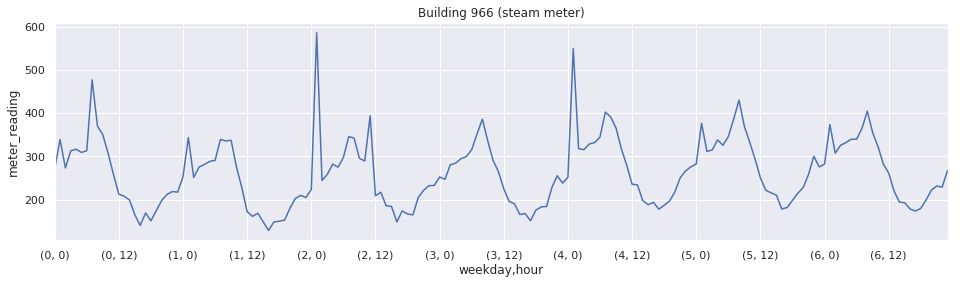

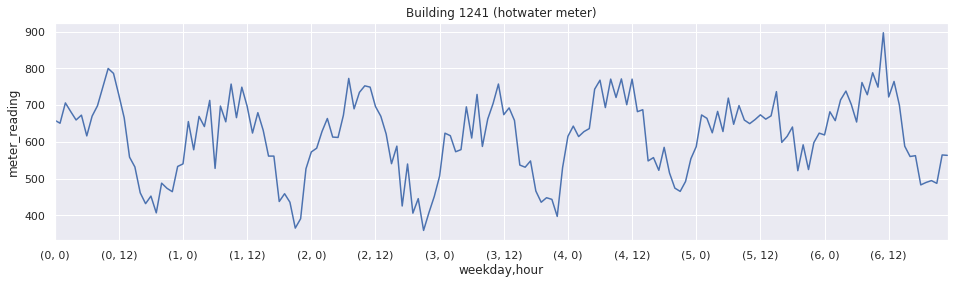

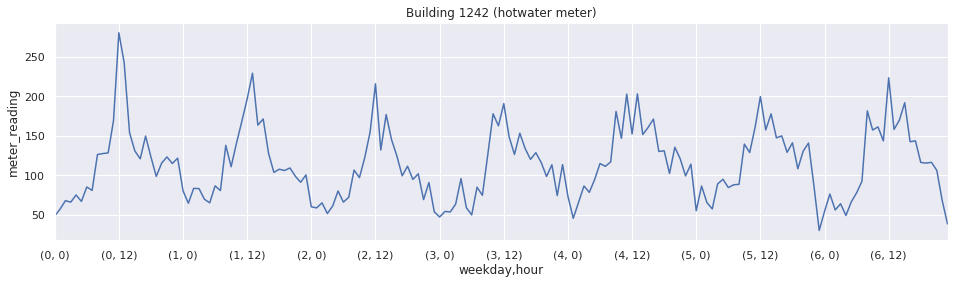

In [ ]:
# Add weekday and hour
meter['weekday'] = meter.timestamp.dt.dayofweek
meter['hour'] = meter.timestamp.dt.hour

# Plot 2 of each
for mtype in metr_loc.keys():
    for bldg in metr_loc[mtype][99:101]:
        fig = plt.figure(figsize=(16, 4))
        meter[(meter.building_id == bldg) & (meter.meter == mtype)].groupby(['weekday', 'hour']).meter_reading.mean().plot(xticks=range(0, 7 * 24, 12))
        plt.ylabel('meter_reading')
        plt.title(f'Building {bldg} ({types[mtype]} meter)')

Electricity meters:
- Usage oscillates between day and night, peaking after noontime in the day
- Usage is lower on weekends

Chilled water meters:
- Usage shows a similar pattern as electricity meters, but usage doesn't decrease over the weekend in building 765 and only decreases a little in building 771
- Usage peaks before noon in building 771

Steam meters:
- Usage also oscillates between day and night, but most peaks occur around midnight

Hot water meters:
- Usage has the same pattern as chilled water meters with no decrease on weekends

##### Plot the meter readings of each meter type by hour

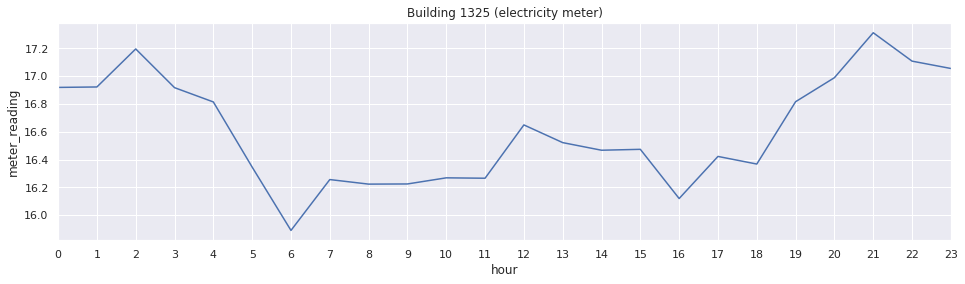

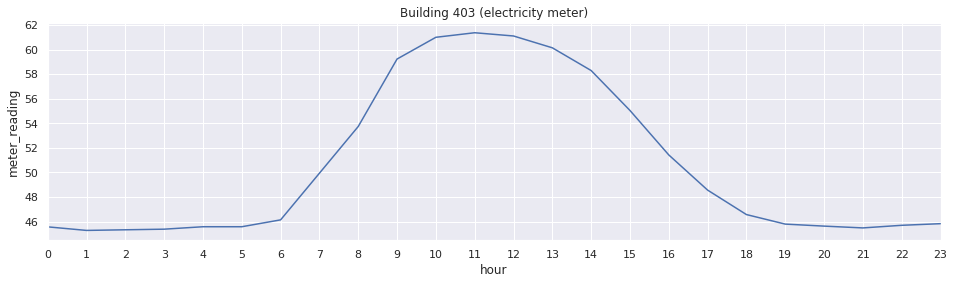

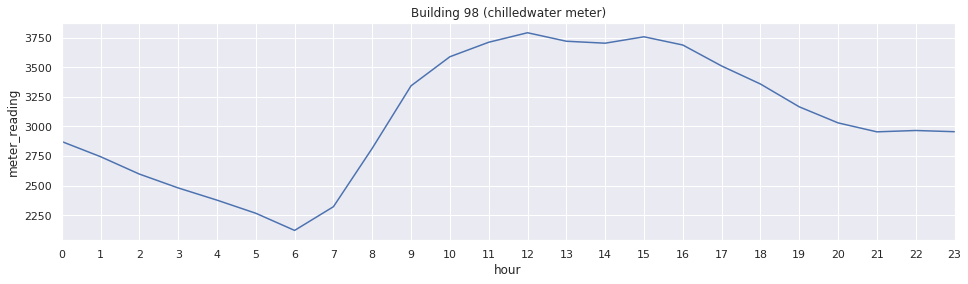

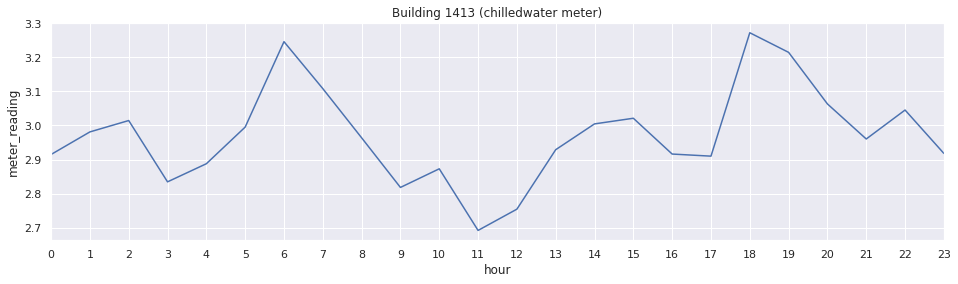

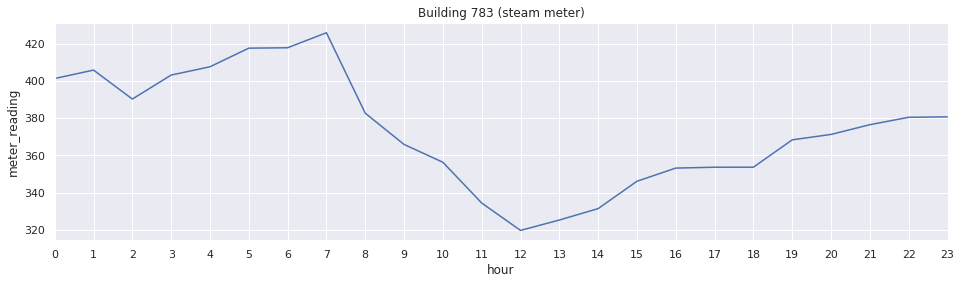

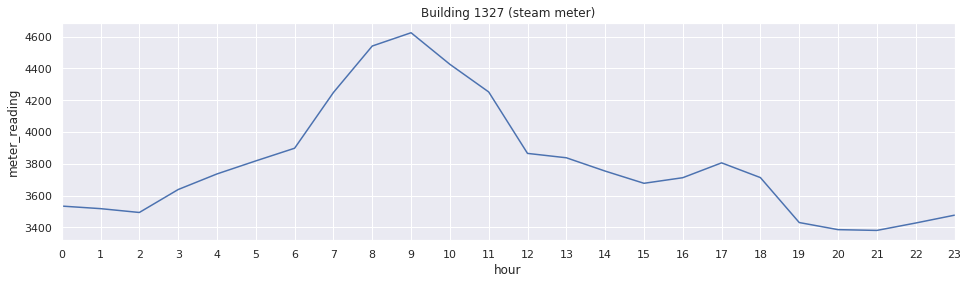

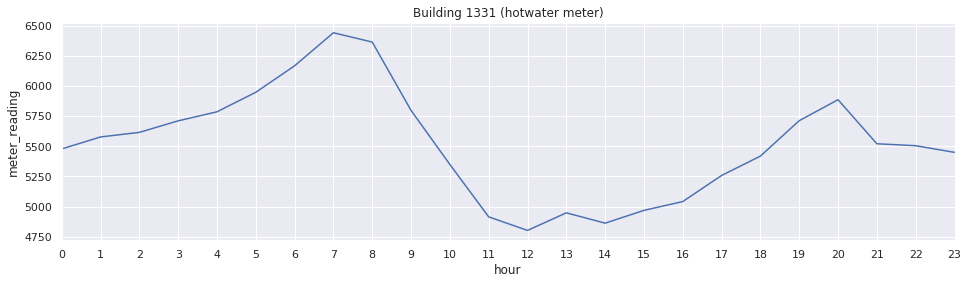

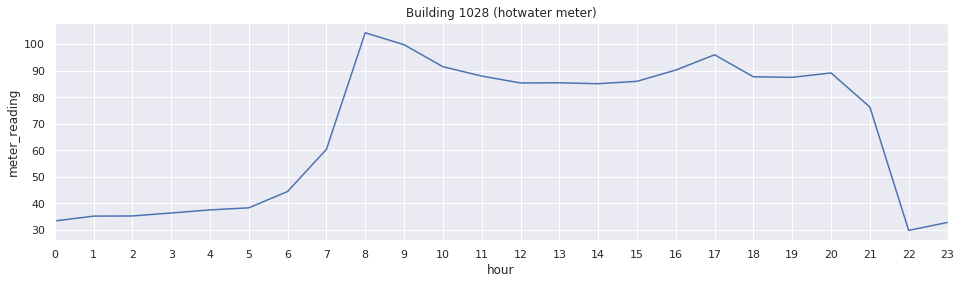

In [ ]:
for mtype in metr_loc.keys():
    for bldg in metr_loc[mtype][-2:]:
        fig = plt.figure(figsize=(16, 4))
        meter[(meter.building_id == bldg) & (meter.meter == mtype)].groupby(['hour']).meter_reading.mean().plot(xticks=range(24))
        plt.ylabel('meter_reading')
        plt.title(f'Building {bldg} ({types[mtype]} meter)')

In [ ]:
del bldg, mtype, fig
gc.collect()

86281

Building 1325 is showing an unexpected pattern, where the electricity usage is peaking at night. There may be a timezone difference in the meter data like there was with the weather data.

##### Check the average hourly electricity usage by site

In [ ]:
site_byhr = meter[meter.type == 'electricity'].pivot_table(index='hour', columns='site_id', values='meter_reading', aggfunc='mean')
site_byhr

site_id         0           1           2           3           4          5   \
hour                                                                            
0        63.360119  143.420258  137.283173  106.031769  157.627380  19.669161   
1        62.298283  142.398682  135.757629  105.924370  155.958618  18.923874   
2        61.359440  140.066162  136.162735  106.380997  153.911057  18.801413   
3        60.547081  139.143631  135.821320  107.456833  152.806046  19.000902   
4        60.138332  138.907684  137.067474  110.239532  152.670410  19.182199   
5        60.895683  139.897415  142.140900  115.426582  155.345657  19.794270   
6        64.118095  144.347321  147.049133  123.525780  163.008987  23.055973   
7        67.662987  150.756805  149.762650  131.332535  173.392334  29.328558   
8        68.730698  159.344696  154.882553  137.490723  183.475479  35.556381   
9        70.372696  168.891266  160.288132  141.927017  193.975708  41.141666   
10       71.889153  177.120697  163.432098  144.213928  200.545364  45.478638   
11       72.907921  182.839371  165.178726  144.912643  205.565491  48.020145   
12       74.222305  186.058441  166.567535  145.025772  207.588684  47.937119   
13       74.784805  187.300644  167.272034  144.719315  210.072769  46.539227   
14       74.831123  187.374451  167.046127  143.596542  210.105392  45.471401   
15       74.660606  187.468735  166.685333  141.657059  209.506546  43.621460   
16       74.208244  186.059875  164.582809  138.777618  206.883347  39.511829   
17       73.233879  182.408798  160.309799  135.109863  199.603119  34.821793   
18       73.223778  176.034470  157.516464  129.110458  192.808487  32.178886   
19       73.730774  168.463470  156.202591  123.436569  186.627838  29.712210   
20       72.645103  159.545853  153.984833  119.915039  180.192139  27.008488   
21       72.132027  153.969788  149.937271  115.013863  172.225143  24.162508   
22       70.202606  149.489685  146.637711  110.454842  164.517471  21.951727   
23       65.708138  145.545303  141.227798  107.369904  160.863586  20.302452   

site_id          6            7          8           9          10  \
hour                                                                 
0        156.827515  1610.026367  65.656799  163.520844  61.564274   
1        154.066422  1602.389893  65.677094  184.159851  62.753059   
2        151.233795  1601.391602  65.758759  154.859085  61.290009   
3        149.168289  1613.572510  65.720970  152.405136  60.973156   
4        149.293030  1710.468384  65.724747  151.101959  60.901524   
5        153.328796  1983.812500  65.736176  152.069061  65.902046   
6        162.070892  2228.479492  65.732796  155.902512  83.366493   
7        172.073914  2355.019287  65.737541  171.350266  81.212097   
8        180.763229  2413.288086  65.767853  177.029892  87.928802   
9        188.295670  2434.108154  65.786171  182.759125  94.242317   
10       193.505478  2448.158936  65.810356  191.396530  95.821953   
11       195.465836  2458.584229  65.832115  196.851089  96.919083   
12       196.232864  2458.184326  65.855827  197.855423  96.714806   
13       198.629257  2451.295654  65.857864  201.091293  96.691833   
14       198.750778  2439.389160  65.865257  201.604523  96.264671   
15       196.757431  2378.451416  65.857193  202.772903  94.624382   
16       194.218018  2289.515137  65.733597  199.684753  91.697762   
17       188.208832  2075.123291  65.677666  196.269913  87.644585   
18       183.165253  1903.539307  65.672714  190.191330  85.776588   
19       180.225052  1806.832275  65.661400  187.251373  82.804604   
20       178.535187  1755.244629  65.654640  183.420822  79.735527   
21       175.430649  1702.010742  65.646072  180.521866  73.056465   
22       170.880753  1657.922363  65.642578  176.022186  67.821510   
23       164.263443  1628.002686  65.641617  169.852921  64.163361   

site_id          11          12          13          14          15  
ho

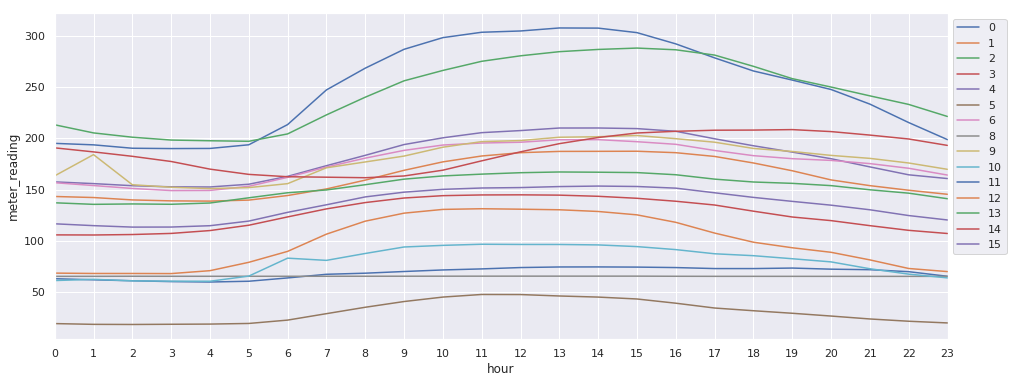

In [ ]:
site_byhr.drop(7, axis=1).plot(figsize=(16, 6), xticks=range(24))
plt.ylabel('meter_reading')
plt.legend(bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'Site 7 electricity meter')

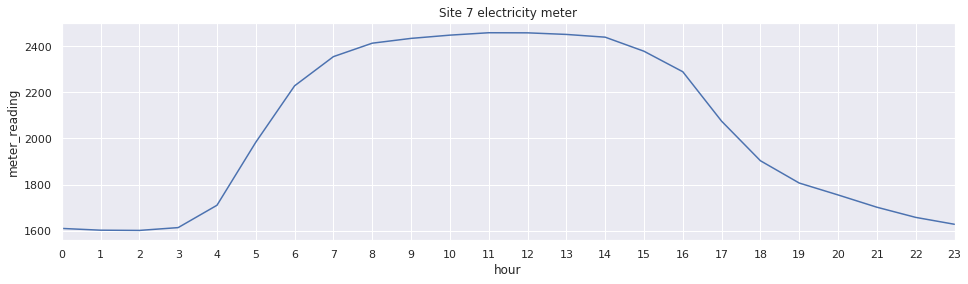

In [ ]:
# The scale of site 7 is much larger
site_byhr[7].plot(xticks=range(24))
plt.ylabel('meter_reading')
plt.title('Site 7 electricity meter')

It doesn't look like the meter was recorded in UCT after all.

##### Plot the average electricity `meter_reading`s by site

In [ ]:
elec_bysite = meter[meter.type == 'electricity'].pivot_table(index='timestamp', columns='site_id', values='meter_reading', aggfunc='mean')
elec_bysite = elec_bysite.resample('d').mean()
elec_bysite.head()

site_id           0           1           2           3           4   \
timestamp                                                              
2016-01-01  0.096517  130.895172  130.235382  107.390465  154.542831   
2016-01-02  0.250731  131.021683  133.014725  106.557686  152.769745   
2016-01-03  0.624257  131.264633  130.550095  103.839539  162.714325   
2016-01-04  0.149355  153.480148  147.911758  133.670670  181.021149   
2016-01-05  0.060936  156.681183  149.458618  143.390198  181.918594   

site_id            5           6            7          8           9   \
timestamp                                                               
2016-01-01  21.133106  150.683929  1784.532715  65.234848  130.623734   
2016-01-02  23.323677  160.404236  1671.163208  67.465805  139.397552   
2016-01-03  22.021584  163.670959  1633.909668  61.591049  134.341553   
2016-01-04  36.395508  184.680084  2176.916504  59.245579  156.081787   
2016-01-05  38.388134  192.533997  2206.263428  52.291134  161.371490   

site_id            10          11          12          13          14  \
timestamp                                                               
2016-01-01  71.033676  197.078125   77.931694  182.164764  166.050903   
2016-01-02  75.223228  197.901047  118.952515  183.805908  170.267502   
2016-01-03  70.096931  196.187500  123.468552  181.031082  170.302750   
2016-01-04  85.848412  235.473953  114.252876  209.805740  189.176422   
2016-01-05  84.937775  238.328125   72.763870  211.803040  197.860458   

site_id             15  
timestamp               
2016-01-01  116.749664  
2016-01-02  117.481873  
2016-01-03  118.852905  
2016-01-04  134.948334  
2016-01-05  136.744919

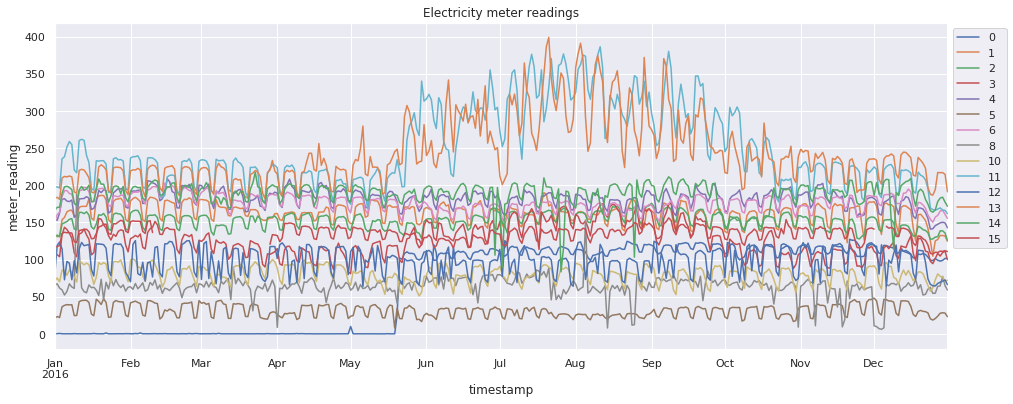

In [ ]:
elec_bysite.drop([7, 9], axis=1).plot(figsize=(16, 6))
plt.title('Electricity meter readings')
plt.ylabel('meter_reading')
plt.legend(bbox_to_anchor=(1, 1))

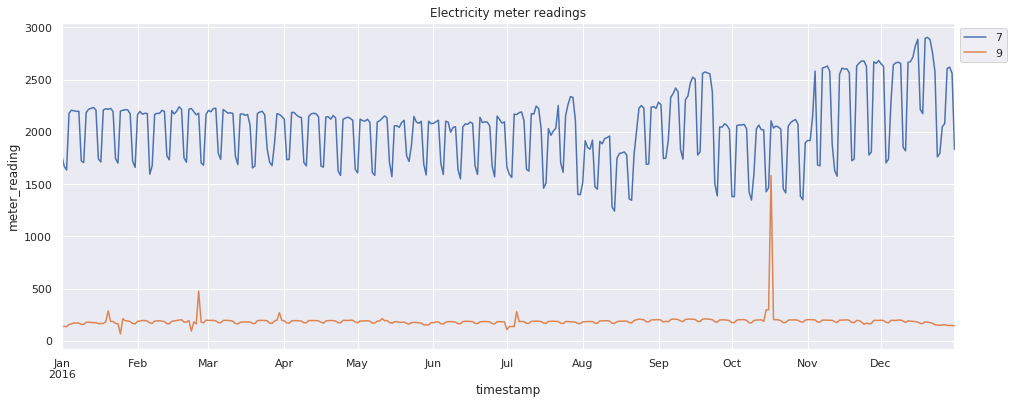

In [ ]:
# Different scale
elec_bysite[[7, 9]].plot(figsize=(16, 6))
plt.title('Electricity meter readings')
plt.ylabel('meter_reading')
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
del bytime, metr_loc, types, site_byhr, elec_bysite
gc.collect()

994

Average electricity meter readings by site:
- A lot, if not all, of buildings in site 0 have meter readings of 0 from the beginning of the year to the middle of May
- Electricity usage in sites 11 and 13 peak during the summer, while it stays relatively constant throughout the year in all other sites
- Electric usage in site 5 is much lower than the others and usage in site 7 is much higher than the others
- There's a huge outlier during October in site 9 that could be an error
- Site 15 is missing `meter_reading`s in February and March

##### Explore the meter data in relation to the building data

In [ ]:
# Encode primary_use into integers
encoder = LabelEncoder()
building['use_encoded'] = encoder.fit_transform(building.primary_use).astype('uint8')

# Extract columns to be used
bldg = building[['building_id', 'use_encoded', 'primary_use', 'year_built', 'square_feet', 'floor_count']]

# Join the dataframes
metr_bldg = pd.merge(meter, bldg, on='building_id', how='left')

# Extract electricity readings
elec = metr_bldg[metr_bldg.type == 'electricity'].drop(['meter', 'type'], axis=1)
elec.head()

site_id  building_id  timestamp  meter_reading  weekday  hour  use_encoded  \
0        0            0 2016-01-01            0.0        4     0            0   
1        0            1 2016-01-01            0.0        4     0            0   
2        0            2 2016-01-01            0.0        4     0            0   
3        0            3 2016-01-01            0.0        4     0            0   
4        0            4 2016-01-01            0.0        4     0            0   

  primary_use  year_built  square_feet  floor_count  
0   Education        2008         7432            1  
1   Education        2004         2720            1  
2   Education        1991         5376            1  
3   Education        2002        23685            1  
4   Education        1975       116607            4

In [ ]:
# Bin year_built
elec['year_bin'] = pd.cut(elec.year_built, bins=12)

# Rename bins
elec.year_bin = elec.year_bin.apply(lambda y: f'{int(y.left)} - {int(y.right)}')

# Pivot table
elec_byyr = elec.pivot_table(index='timestamp', columns='year_bin', values='meter_reading', aggfunc='mean')
elec_byyr = elec_byyr.resample('d').mean()

elec_byyr.head()

year_bin    1899 - 1909  1909 - 1919  1919 - 1928  1928 - 1938  1938 - 1947  \
timestamp                                                                     
2016-01-01   121.621468    32.451256   155.969711   101.398750    97.497292   
2016-01-02   119.941292    33.477684   153.613998    94.756950    97.151222   
2016-01-03   118.283661    34.670742   145.618973   101.638206    96.996948   
2016-01-04   142.185333    48.149437   187.661774   121.366280   122.671997   
2016-01-05   145.737656    50.493839   198.730042   123.699944   128.843781   

year_bin    1947 - 1957  1957 - 1967  1967 - 1976  1976 - 1986  1986 - 1995  \
timestamp                                                                     
2016-01-01   210.191589   136.583481   106.111443   153.542572   206.321976   
2016-01-02   203.365814   142.748718   106.659256   153.295578   207.317780   
2016-01-03   203.711273   141.067139   103.656746   155.412735   207.764648   
2016-01-04   248.708252   161.052307   127.378815   195.371902   237.402283   
2016-01-05   252.092682   161.762238   130.501480   206.747299   242.604797   

year_bin    1995 - 2005  2005 - 2015  
timestamp                             
2016-01-01    54.768349   202.994507  
2016-01-02    55.379967   200.065918  
2016-01-03    54.670670   199.348419  
2016-01-04    61.997517   232.484970  
2016-01-05    62.830421   241.898209

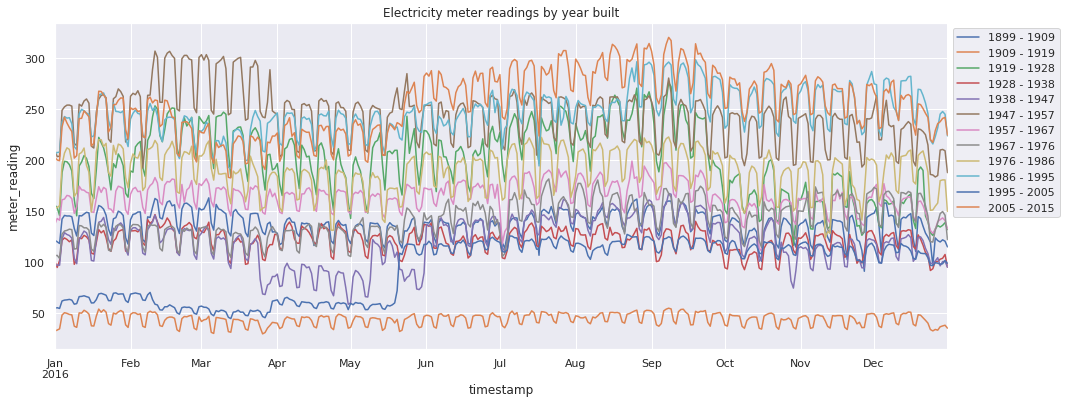

In [ ]:
elec_byyr.plot(figsize=(16, 6))
plt.title('Electricity meter readings by year built')
plt.ylabel('meter_reading')
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
# Electricity by primary_use (month)
elec_byuse = elec.pivot_table(index='timestamp', columns='primary_use', values='meter_reading', aggfunc='mean').resample('d').mean()
elec_byuse.head()

primary_use   Education  Entertainment/public assembly  \
timestamp                                                
2016-01-01   191.499374                      85.596504   
2016-01-02   191.513809                      96.491936   
2016-01-03   190.296509                      93.125786   
2016-01-04   227.763962                      96.145775   
2016-01-05   230.804520                      94.447968   

primary_use  Food sales and service  Healthcare  Lodging/residential  \
timestamp                                                              
2016-01-01                57.775269  252.617203            54.889503   
2016-01-02                56.004456  254.700851            55.898479   
2016-01-03                55.678207  252.124695            54.641193   
2016-01-04                65.751213  283.154022            58.558826   
2016-01-05                69.037048  297.571045            62.690994   

primary_use  Manufacturing/industrial      Office      Other    Parking  \
timestamp                                                                 
2016-01-01                  76.058975  115.350121  36.339516  42.593391   
2016-01-02                  87.069824  115.346275  36.163048  43.160042   
2016-01-03                  87.500557  113.910797  35.471798  42.704491   
2016-01-04                  96.065186  144.028381  36.192486  44.970306   
2016-01-05                  97.545601  148.179092  38.081638  45.856644   

primary_use  Public services  Religious worship     Retail   Services  \
timestamp                                                               
2016-01-01         80.129852           3.547153  18.020487  57.391514   
2016-01-02         82.644180           3.206805  28.480412  59.183315   
2016-01-03         82.307068           3.979583  30.613329  57.660202   
2016-01-04         96.434464           4.500556  29.830788  63.199398   
2016-01-05        100.895615           4.402709  20.724955  63.557858   

primary_use  Technology/science     Utility  Warehouse/storage  
timestamp                                                       
2016-01-01            77.231125   85.041168          43.744831  
2016-01-02            82.299454  108.146927          44.119267  
2016-01-03            80.178719   84.347191          40.700291  
2016-01-04            93.097458  118.440781          49.387871  
2016-01-05            91.389580  100.911018          54.734837

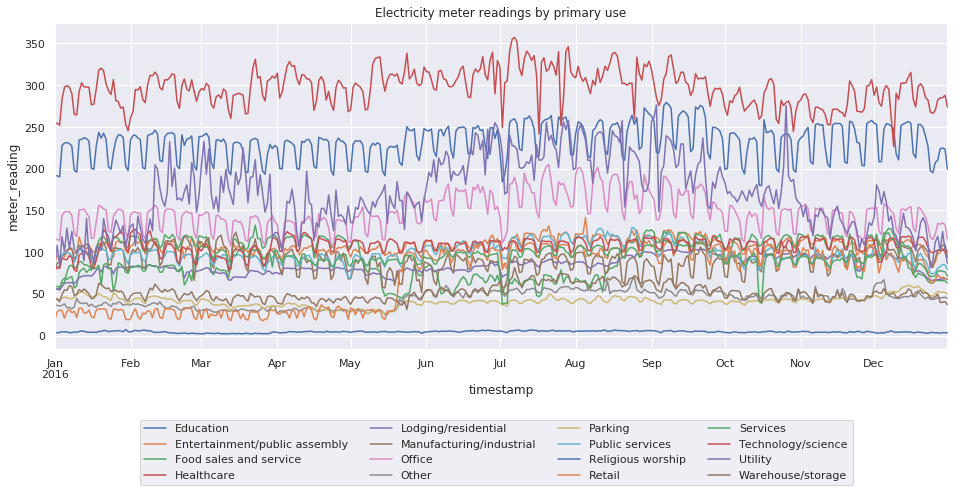

In [ ]:
elec_byuse.plot(figsize=(16, 6))
plt.title('Electricity meter readings by primary use')
plt.ylabel('meter_reading')
plt.legend(bbox_to_anchor=(0.9, -0.2), ncol=4, fancybox=True)

In [ ]:
# Electricity by primary_use (weekday)
elec_byuse_wkdy = elec.pivot_table(index=['weekday', 'hour'], columns='primary_use', values='meter_reading', aggfunc='mean')
elec_byuse_wkdy.head()

primary_use    Education  Entertainment/public assembly  \
weekday hour                                              
0       0     196.207718                      91.271790   
        1     199.071411                      92.209259   
        2     194.131424                      87.730972   
        3     194.235641                      87.002861   
        4     199.145126                      87.616203   

primary_use   Food sales and service  Healthcare  Lodging/residential  \
weekday hour                                                            
0       0                  97.004433  279.276581            84.729111   
        1                  83.892792  278.015167            84.247627   
        2                  72.538979  275.975433            76.427116   
        3                  68.750313  274.258911            73.385765   
        4                  70.956856  272.354279            71.715714   

primary_use   Manufacturing/industrial      Office      Other    Parking  \
weekday hour                                                               
0       0                    61.803600  123.111450  39.027328  42.295918   
        1                    55.815136  123.354736  39.153103  41.788727   
        2                    54.773514  122.251930  39.150162  41.673603   
        3                    57.420322  122.263489  39.258045  41.494301   
        4                    60.839901  123.692741  39.530170  41.373753   

primary_use   Public services  Religious worship     Retail   Services  \
weekday hour                                                             
0       0           88.807083           3.195473  50.294434  91.196373   
        1           86.445236           3.075135  49.589802  92.596680   
        2           84.987732           3.111712  49.319744  90.691048   
        3           84.271263           3.026115  48.683914  90.683159   
        4           83.562408           3.137466  51.805233  90.542557   

primary_use   Technology/science     Utility  Warehouse/storage  
weekday hour                                                     
0       0              94.642067  241.272141          46.853474  
        1              94.824768  230.983322          45.896481  
        2              94.833382  221.662231          45.540424  
        3              94.926674  217.804306          45.273338  
        4              96.034981  211.218094          45.328941

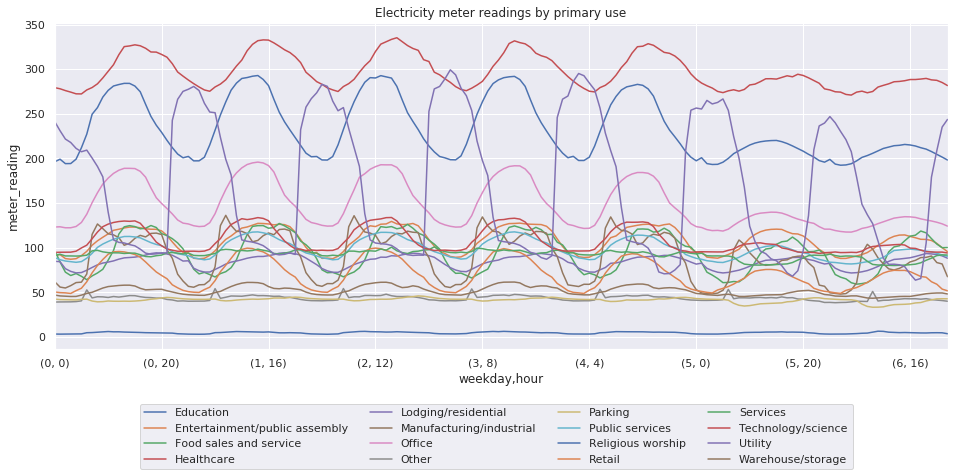

In [ ]:
elec_byuse_wkdy.plot(figsize=(16, 6))
plt.title('Electricity meter readings by primary use')
plt.ylabel('meter_reading')
plt.legend(bbox_to_anchor=(0.9, -0.15), ncol=4, fancybox=True)

In [ ]:
# Electricity by floor_Count
elec_byflr = elec.pivot_table(index='timestamp', columns='floor_count', values='meter_reading', aggfunc='mean').resample('d').mean()
elec_byflr.head()

floor_count         1          2           3           4           5   \
timestamp                                                               
2016-01-01   32.022156  50.183445  101.271469  117.811394  219.851837   
2016-01-02   33.451046  52.156811  102.974823  124.108658  217.229111   
2016-01-03   31.679157  51.892334  101.702202  125.381416  214.449463   
2016-01-04   34.623013  62.472523  123.625275  146.077026  257.775269   
2016-01-05   34.389275  63.774090  127.528435  143.048538  263.426666   

floor_count          6           7           8           9           10  ...  \
timestamp                                                                ...   
2016-01-01   255.779022  261.198700  299.283813  426.503387  408.430939  ...   
2016-01-02   252.332977  264.357513  306.526123  434.069977  406.871368  ...   
2016-01-03   253.708893  266.545776  307.207703  429.176575  403.317169  ...   
2016-01-04   293.939606  295.629456  344.445465  516.893982  441.935852  ...   
2016-01-05   296.122620  298.961945  348.672272  525.479004  435.553925  ...   

floor_count           14          15          16          17          18   19  \
timestamp                                                                       
2016-01-01    989.894470  333.011963  196.445831  355.218903  816.774414  0.0   
2016-01-02    997.820984  361.331787  314.568756  357.145721  822.562561  0.0   
2016-01-03    987.949890  360.598114  246.806244  351.408173  820.711670  0.0   
2016-01-04   1084.777832  426.900299  252.337494  383.551727  948.259705  0.0   
2016-01-05   1093.231812  501.358856  354.725006  398.633331  951.415161  0.0   

floor_count           21          23          25           26  
timestamp                                                      
2016-01-01    818.515747  554.958313  641.960449   914.876892  
2016-01-02    749.356567  579.000000  656.871460   882.035461  
2016-01-03    684.585327  235.416672  675.250000   863.442810  
2016-01-04   1184.096558  211.125000  740.140869  1068.046631  
2016-01-05   1214.948608  628.375000  799.099609  1138.945068  

[5 rows x 23 columns]

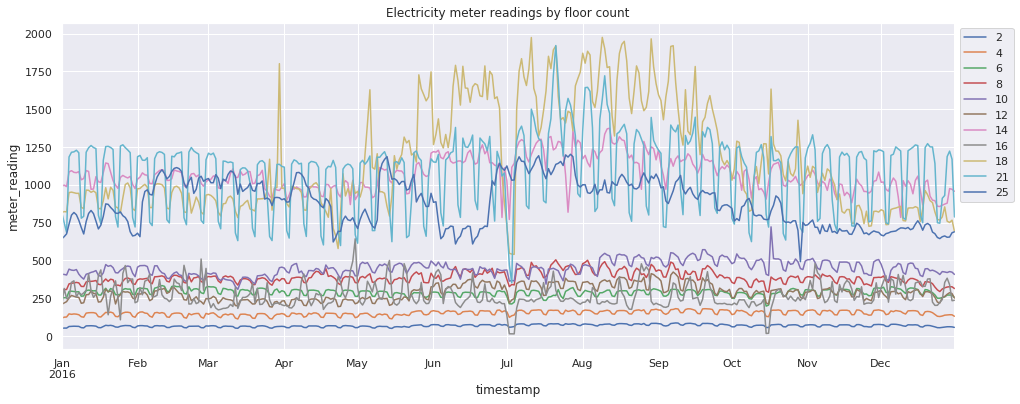

In [ ]:
elec_byflr.iloc[:, 1::2].plot(figsize=(16, 6))
plt.title('Electricity meter readings by floor count')
plt.ylabel('meter_reading')
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
# Bin square_feet
elec['sqft_bin'] = pd.cut(elec.square_feet, bins=16)

# Rename bins
elec.sqft_bin = elec.sqft_bin.apply(lambda y: f'{int(y.left)} - {int(y.right)}')

# Pivot table
elec_bysqft = elec.pivot_table(index='timestamp', columns='sqft_bin', values='meter_reading', aggfunc='mean')
elec_bysqft = elec_bysqft.resample('d').mean()

elec_bysqft.head()

sqft_bin    -591 - 54952  54952 - 109622  109622 - 164292  164292 - 218962  \
timestamp                                                                    
2016-01-01     31.045238       88.193924       187.102356       307.828308   
2016-01-02     32.029026       91.892799       192.173157       313.649109   
2016-01-03     31.612366       89.881569       191.684067       311.036163   
2016-01-04     36.276798      108.289238       220.527390       352.844788   
2016-01-05     37.543266      111.730164       221.317444       352.731506   

sqft_bin    218962 - 273632  273632 - 328301  328301 - 382971  \
timestamp                                                       
2016-01-01       369.167389       472.094727       304.982574   
2016-01-02       372.624237       470.609131       315.186859   
2016-01-03       380.574554       463.899109       317.564087   
2016-01-04       421.132294       563.300476       397.579803   
2016-01-05       426.302216       574.562866       409.789276   

sqft_bin    382971 - 437641  437641 - 492311  492311 - 546981  \
timestamp                                                       
2016-01-01       476.406769      1340.339722       280.035553   
2016-01-02       447.841614      1308.299072       341.857819   
2016-01-03       437.121185      1291.798096       300.671173   
2016-01-04       578.673584      1502.847290       352.780182   
2016-01-05       589.180969      1557.258911       408.764496   

sqft_bin    546981 - 601650  656320 - 710990  710990 - 765660  \
timestamp                                                       
2016-01-01       539.606689       535.254456      2043.415283   
2016-01-02       543.278809       603.707581      2013.114624   
2016-01-03       543.430481       608.985046      1820.781616   
2016-01-04       624.206726       687.492798      2669.357666   
2016-01-05       636.168762       688.438477      2857.407471   

sqft_bin    765660 - 820330  820330 - 875000  
timestamp                                     
2016-01-01       641.960449      1420.556885  
2016-01-02       656.871460      1348.828857  
2016-01-03       675.250000      1335.789551  
2016-01-04       740.140869      1668.173340  
2016-01-05       799.099609      1477.958374

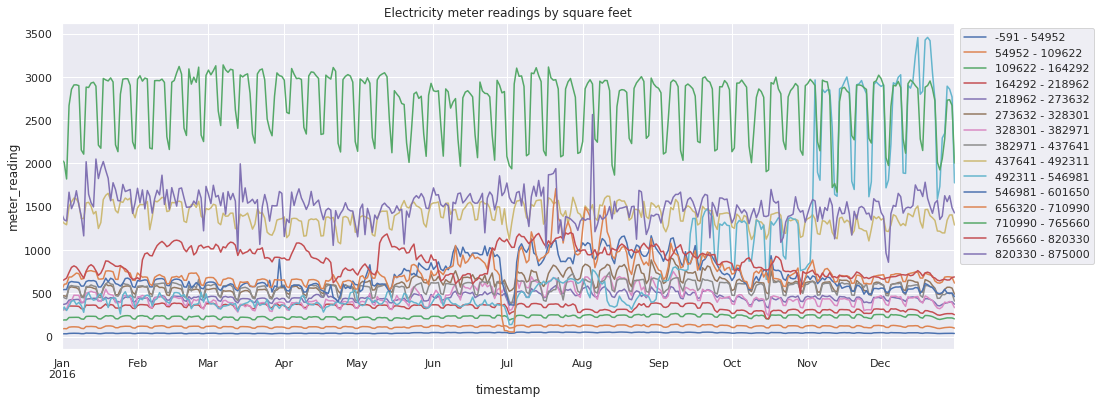

In [ ]:
# Electricity by square_feet
elec_bysqft.plot(figsize=(16, 6))
plt.title('Electricity meter readings by square feet')
plt.ylabel('meter_reading')
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
del bldg, elec, elec_byyr, elec_byuse, elec_byuse_wkdy, elec_byflr, elec_bysqft
gc.collect()

1139

Electric usage based on `year_built`:
- Usage in buildings that opened between 1909 and 1919 are much less than the rest
    - Could it mean these buildings are more efficient? Or do they just use less electricity in general?
- Buildings that opened between 1947 to 1957, 1986 to 1995, and 2015 to 2015 are showing the highest usage
- Peak usage most commonly occurs between February to March and August to September

Electric usage based on `primary_use` (by month):
- Religious worship buildings have the lowest usage
- Health care buildings have the highest usage, followed by education buildings
- Food sales and service buildings see a significant drop in usage in the Summer months and around New Year
- Lodging and residential buildings use the most electricity at the end of the year
- A lot of buildings show a peak in the Summer

Electric usage based on `primary_use` (by weekday):
- Usage is lower on the weekends for about half the building types
- Usage oscillates through day and night for most buildings
    - The oscillations of utility building usage has the greatest amplitude (wave height)
    - This oscillation isn't as obvious in services buildings and parking structures
- Even at night, health care buildings are using more electricity than most other buildings during the day

Electric usage based on `floor_count`:
- For the most part, as the `floor_count` increases, so does usage
    - A few of the higher `floor_count`s fall out of this linear pattern
        A lot of these higher `floor_count`s were originally missing

Electric usage based on `square_feet`:
- For the most part, as the `square_feet` increases, so does usage (just like with `floor_Count`)
    A few `square_feet` bins show usage that is higher than usual (based on the linear pattern)

##### Check the correlation between the `meter_reading` and all other features

In [ ]:
# Add month and day
metr_bldg['month'] = metr_bldg.timestamp.dt.month
metr_bldg['day'] = metr_bldg.timestamp.dt.day

columns = ['site_id', 'building_id', 'use_encoded', 'primary_use', 'year_built', 'floor_count', 'square_feet', 'timestamp', 'month', 'day', 'hour', 'weekday', 'meter', 'type', 'meter_reading']
metr_bldg = metr_bldg[columns]
metr_bldg.head()

site_id  building_id  use_encoded primary_use  year_built  floor_count  \
0        0            0            0   Education        2008            1   
1        0            1            0   Education        2004            1   
2        0            2            0   Education        1991            1   
3        0            3            0   Education        2002            1   
4        0            4            0   Education        1975            4   

   square_feet  timestamp  month  day  hour  weekday  meter         type  \
0         7432 2016-01-01      1    1     0        4      0  electricity   
1         2720 2016-01-01      1    1     0        4      0  electricity   
2         5376 2016-01-01      1    1     0        4      0  electricity   
3        23685 2016-01-01      1    1     0        4      0  electricity   
4       116607 2016-01-01      1    1     0        4      0  electricity   

   meter_reading  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [ ]:
# Extract columns to be used
columns = ['site_id', 'timestamp', 'air_temperature', 'dew_temperature', 'sea_level_pressure', 'cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'wind_speed']
wthr = weather[columns]

# Join the dataframes
train_df = pd.merge(metr_bldg, wthr, on=['site_id', 'timestamp'], how='left')

print(train_df.shape)
train_df.head()

(20137746, 22)


site_id  building_id  use_encoded primary_use  year_built  floor_count  \
0        0            0            0   Education        2008            1   
1        0            1            0   Education        2004            1   
2        0            2            0   Education        1991            1   
3        0            3            0   Education        2002            1   
4        0            4            0   Education        1975            4   

   square_feet  timestamp  month  day  ...  meter         type  meter_reading  \
0         7432 2016-01-01      1    1  ...      0  electricity            0.0   
1         2720 2016-01-01      1    1  ...      0  electricity            0.0   
2         5376 2016-01-01      1    1  ...      0  electricity            0.0   
3        23685 2016-01-01      1    1  ...      0  electricity            0.0   
4       116607 2016-01-01      1    1  ...      0  electricity            0.0   

  air_temperature  dew_temperature  sea_level_pressure  cloud_coverage  \
0            19.4             19.4         1019.762939             4.0   
1            19.4             19.4         1019.762939             4.0   
2            19.4             19.4         1019.762939             4.0   
3            19.4             19.4         1019.762939             4.0   
4            19.4             19.4         1019.762939             4.0   

   precip_depth_1_hr  wind_direction  wind_speed  
0                0.0           360.0         0.0  
1                0.0           360.0         0.0  
2                0.0           360.0         0.0  
3                0.0           360.0         0.0  
4                0.0           360.0         0.0  

[5 rows x 22 columns]

In [ ]:
# Take a subset of the data
subset = train_df.sample(frac=0.1, random_state=42)
subset.shape

(2013775, 22)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Text xticklabel objects>)

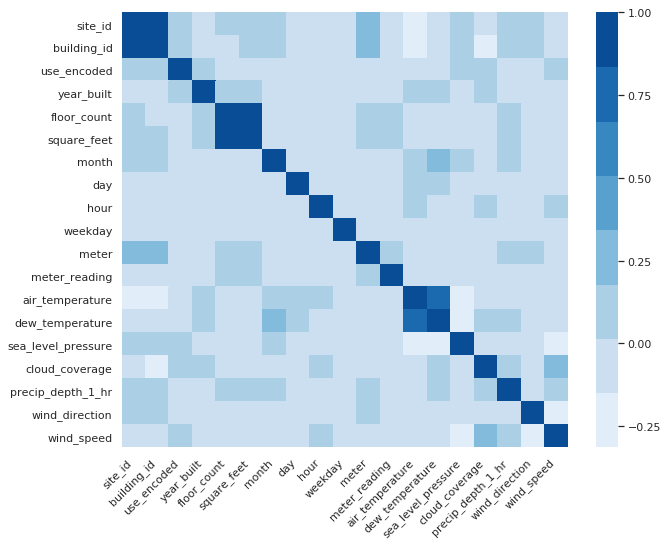

In [ ]:
# Pearson correlation
pearson = train_df.corr()

fig = plt.figure(figsize=(10, 8))
sns.heatmap(pearson, cmap=sns.color_palette('Blues', 8))
plt.xticks(rotation=45, ha='right')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Text xticklabel objects>)

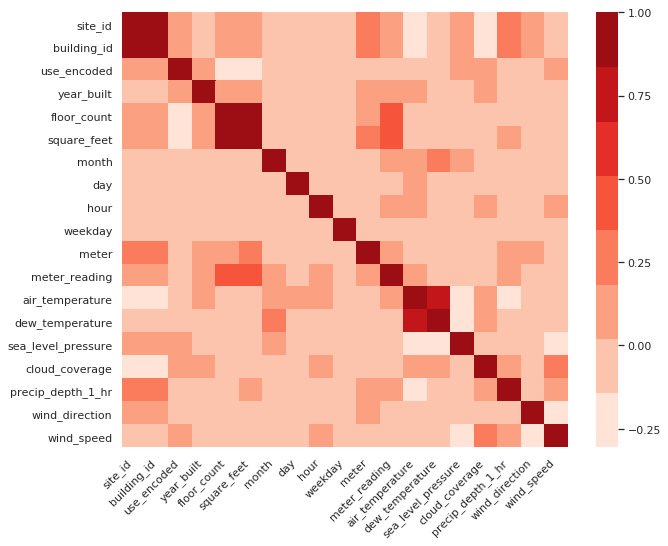

In [ ]:
# Spearman correlation
spearman = subset.corr(method='spearman')

fig = plt.figure(figsize=(10, 8))
sns.heatmap(spearman, cmap=sns.color_palette('Reds', 8))
plt.xticks(rotation=45, ha='right')

Text(0.5, 0, 'Pearson coefficient')

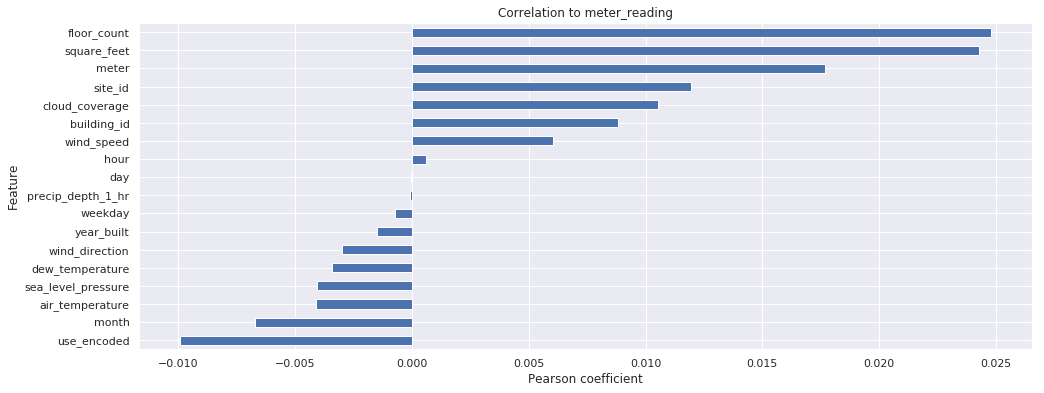

In [ ]:
# Pearson correlation
pearson.meter_reading.sort_values()[:-1].plot(kind='barh', figsize=(16, 6))
plt.title('Correlation to meter_reading')
plt.ylabel('Feature')
plt.xlabel('Pearson coefficient')

Text(0.5, 0, 'Spearman coefficient')

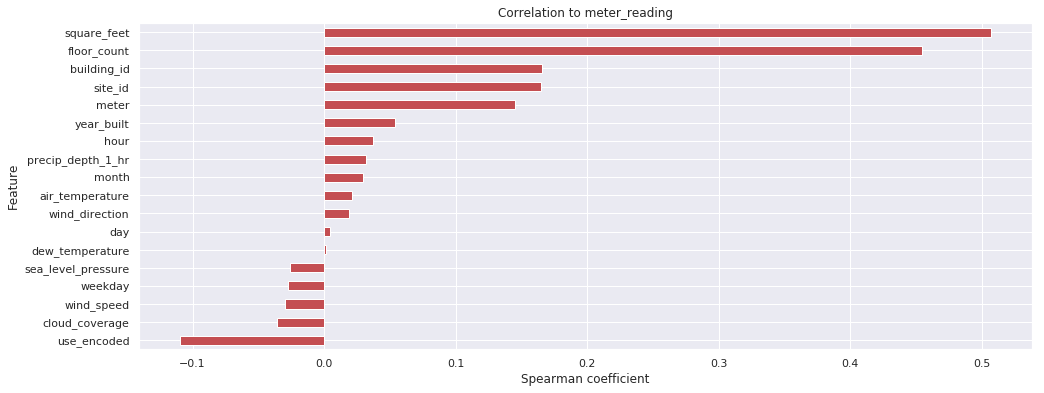

In [ ]:
# Spearman correlation
spearman.meter_reading.sort_values()[:-1].plot(kind='barh', figsize=(16, 6), color='r')
plt.title('Correlation to meter_reading')
plt.ylabel('Feature')
plt.xlabel('Spearman coefficient')

In [ ]:
del pearson, spearman, subset, metr_bldg, wthr, columns, encoder, fig
gc.collect()

50

The size of the building is showing the greatest correlation with `meter_reading` so `square_feet` and `floor_count` may be the most important features when modeling.

The building and meter dataframes were edited here and the combined dataframe was newly created.

##### Save these dataframes into csv files

In [ ]:
building.to_csv(f'{data_path}eda_building.csv')
meter.to_csv(f'{data_path}eda_meter.csv')
train_df.to_csv(f'{data_path}eda_train.csv')

[Back to top](#content1)